In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random as rn
from os.path import join, getsize
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.style as style


from PIL import Image
from tqdm import tqdm

setting dynamic memory

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#InteractiveSession().close

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

## Load Dataset

In [3]:
BATCH_SIZE = 18
CHANNELS = 3
IMG_HEIGHT = 260
IMG_WIDTH = 260
IMG_SIZE=(IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE=IMG_SIZE + (3,)  # --> (224,224,3)
NUM_CLASSES=7
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024

Utilities

In [4]:
def reset_random_seed():
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]=str(2)

  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(2)

  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(2)

  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(2)
  

def get_dataset(path, img_size = IMG_SIZE, batch_size = BATCH_SIZE, shuffle = True):
    """ Get the dataset given the directory name.
    Args:
    - apth (str): a string representing the name of the directory from which the dataset is retrieved.
    
    Returns:
    - ds (PrefetchDataset): a Dataset containing the elements in the directory.
  """
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        seed = 2,
        image_size = img_size,
        batch_size = batch_size,
        shuffle = shuffle
    )


def show_history_fit(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(9, 9))
  plt.subplot(2, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


def compile_model(model, optimizer = 'adam', learning_rate = 0.0001):

  if optimizer == 'rmsprop':
    model.compile(
      optimizer = tf.keras.optimizers.RMSprop(learning_rate),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = ['accuracy']
    )
  elif optimizer == 'adam':
    model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = ['accuracy']
    )
  elif optimizer == 'sgd':
    model.compile(
      optimizer = tf.keras.optimizers.SGD(learning_rate),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = ['accuracy']
    )
  
  model.summary()


def fit_model(model, train, validation, path_model, epochs_par = 30, patience_par = 6):

  earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience= patience_par, verbose=1)

  checkpoint = ModelCheckpoint(path_model,   
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
  )

  history = model.fit(train, epochs= epochs_par,
                        validation_data=validation,
                        verbose=1,
                        shuffle=True, 
                        callbacks=[earlystopping, checkpoint])

  return history, model


def load_best_model_and_evaluate(path, test, optimizer = 'adam', learning_rate = 0.0001, compile = False):

  model = tf.keras.models.load_model(path)

  if compile:
    compile_model(model, optimizer, learning_rate)

  model.evaluate(test)


  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = 1))

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  print(predicted_labels)
  print(correct_labels)

  print("Classification report: ")
  print(metrics.classification_report(correct_labels,predicted_labels,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)


def plot_class_distribution(path, name):
  """ Plot in a bar char the class distribution of data contained in the directory passed as parameter."""
  
  classes = [name for name in os.listdir(path)] 
  class_distribution = {}
  for dir in classes:
    CURR_DIR = path + "/" + dir
    class_distribution[dir] = len([name for name in os.listdir(CURR_DIR) if os.path.isfile(os.path.join(CURR_DIR, name))])

  total = 0
  for class_ in class_distribution:
    print(f'{class_}: {class_distribution[class_]}')
    total += class_distribution[class_]

  print()
  print(f'Total:{total}')

  fig, axes = plt.subplots(figsize=(10,len(class_distribution)))
  plt.bar(class_distribution.keys(), height=class_distribution.values())
  plt.title(f'Barplot of class distribution of {name} dataset');


  

In [5]:
path_dataset = './multi_class_dataset_splitted_balanced/'
path_train = path_dataset + 'train/'
path_validation = path_dataset + 'validation/'
path_test = path_dataset + 'test/'


In [6]:
reset_random_seed()
train_ds = get_dataset(path_train)
val_ds = get_dataset(path_validation)
test_ds = get_dataset(path_test)

Found 28000 files belonging to 7 classes.
Found 2622 files belonging to 7 classes.
Found 2622 files belonging to 7 classes.


amusement: 4000
awe: 4000
contentment: 4000
disgust: 4000
excitement: 4000
fear: 4000
sadness: 4000

Total:28000
amusement: 225
awe: 353
contentment: 1324
disgust: 33
excitement: 84
fear: 260
sadness: 343

Total:2622
amusement: 203
awe: 382
contentment: 1323
disgust: 51
excitement: 73
fear: 278
sadness: 312

Total:2622


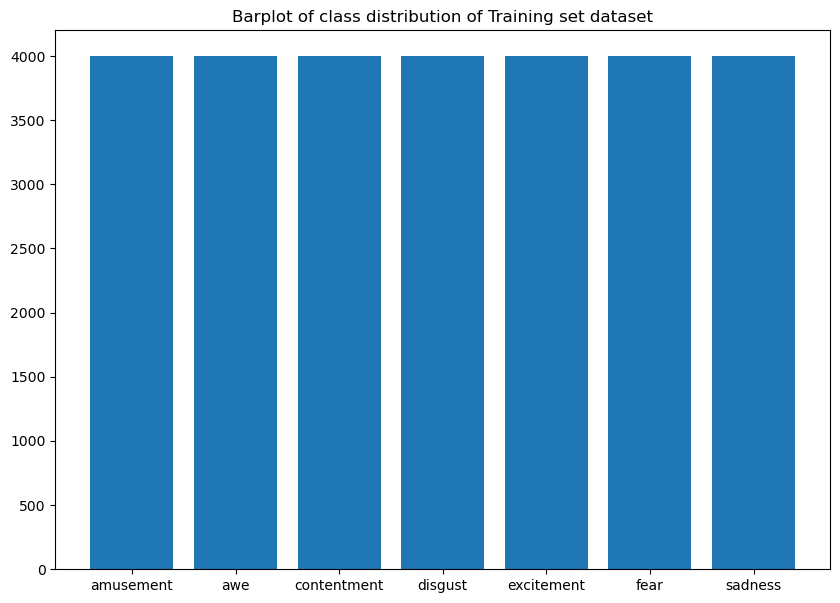

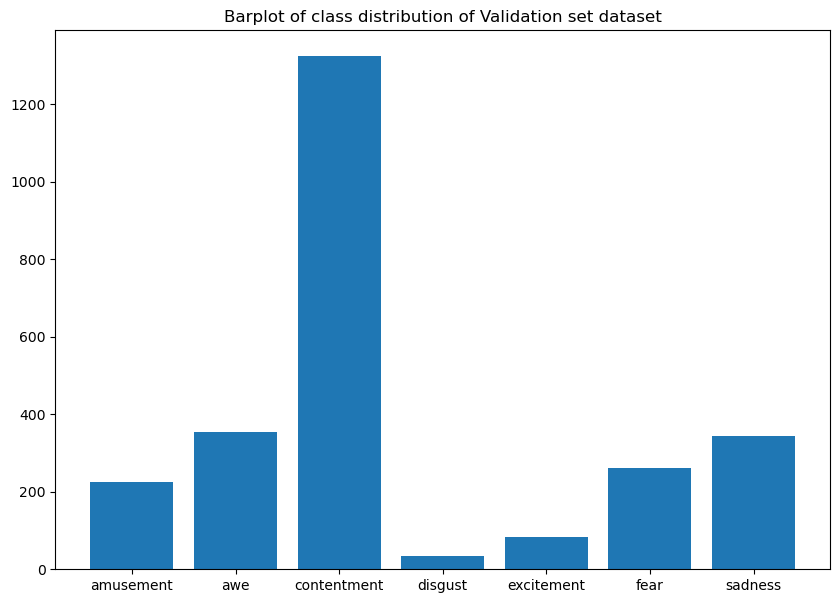

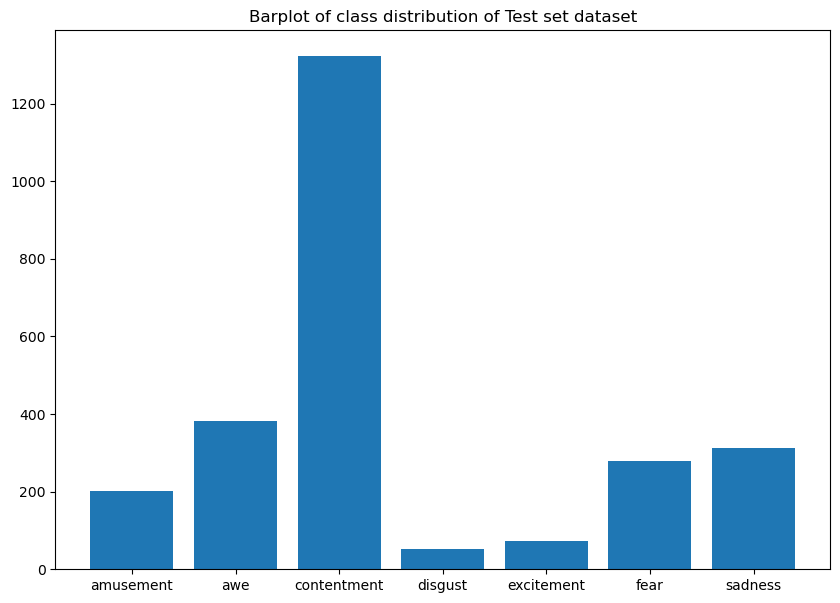

In [7]:
plot_class_distribution(path_train, 'Training set')

plot_class_distribution(path_validation, 'Validation set')

plot_class_distribution(path_test, 'Test set')

In [8]:
print(train_ds.class_names)


['amusement', 'awe', 'contentment', 'disgust', 'excitement', 'fear', 'sadness']


tf.Tensor([1 0 2 3 6 6 5 2 5 0 0 3 1 5 1 3 0 6], shape=(18,), dtype=int32)


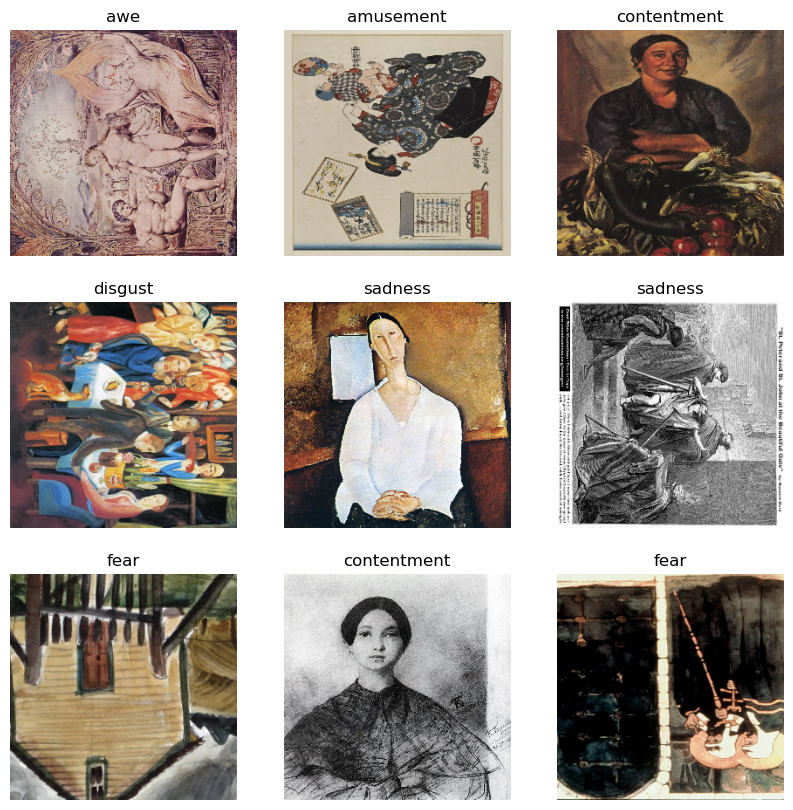

In [9]:
#visualize train samples
tf.random.set_seed(123)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(labels)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [10]:
#train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size = AUTOTUNE)
#val_ds = val_ds.shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size = AUTOTUNE)
#test_ds = test_ds.shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size = AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

## SCRATCH CNN

### Experiment 0 (38,22. andamento buono)

Tiny example

In [12]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((5, 5))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((5, 5))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)#x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs=input, outputs = output)

In [13]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                         

In [14]:
path_model = './multiclass_models_sc/ex0_scratch_32_128_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
438/438 [==============================] - ETA: 0s - loss: 1.8795 - accuracy: 0.2258
Epoch 00001: val_loss improved from inf to 1.86091, saving model to ./multiclass_models_sc\ex0_scratch_32_128_epoch_30_adam_1e-4.h5
438/438 [==============================] - 85s 160ms/step - loss: 1.8795 - accuracy: 0.2258 - val_loss: 1.8609 - val_accuracy: 0.2899
Epoch 2/30
438/438 [==============================] - ETA: 0s - loss: 1.7741 - accuracy: 0.2925
Epoch 00002: val_loss improved from 1.86091 to 1.76623, saving model to ./multiclass_models_sc\ex0_scratch_32_128_epoch_30_adam_1e-4.h5
438/438 [==============================] - 72s 161ms/step - loss: 1.7741 - accuracy: 0.2925 - val_loss: 1.7662 - val_accuracy: 0.3330
Epoch 3/30
437/438 [============================>.] - ETA: 0s - loss: 1.7431 - accuracy: 0.3094
Epoch 00003: val_loss improved from 1.76623 to 1.73885, saving model to ./multiclass_models_sc\ex0_scratch_32_128_epoch_30_adam_1e-4.h5
438/438 [==============================]

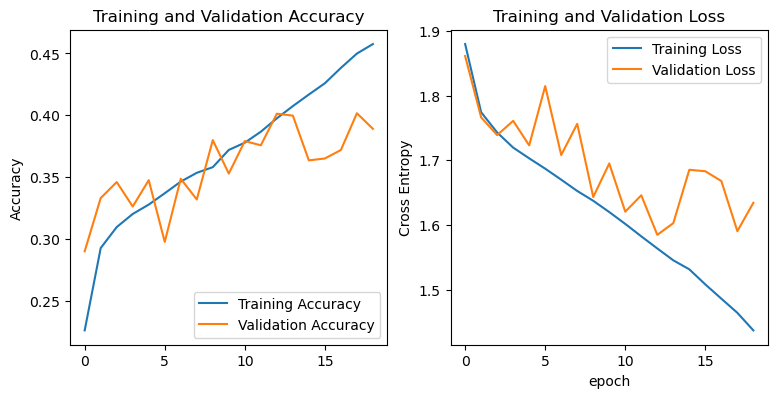

In [15]:
show_history_fit(history)

41/41 [==============================] - 5s 89ms/step - loss: 1.5848 - accuracy: 0.3822
tf.Tensor([2 5 2 ... 5 5 1], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2538    0.3251    0.2851       203
           1     0.2461    0.3298    0.2819       382
           2     0.7592    0.4505    0.5655      1323
           3     0.0756    0.1765    0.1059        51
           4     0.1009    0.3014    0.1512        73
           5     0.2717    0.4173    0.3291       278
           6     0.2226    0.2147    0.2186       312

    accuracy                         0.3822      2622
   macro avg     0.2757    0.3165    0.2767      2622
weighted avg     0.4982    0.3822    0.4156      2622



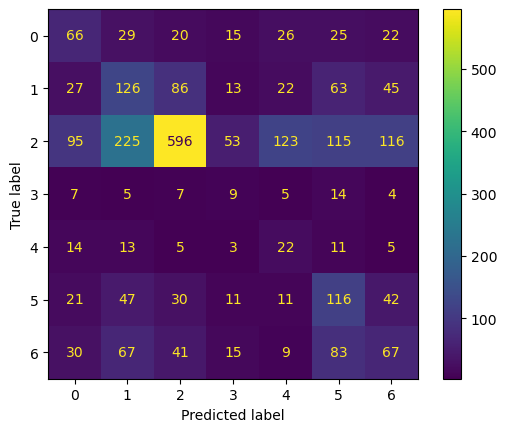

In [16]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 1 (40.92 andamento overfitt)

In [17]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)


x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu'))
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu'))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(2048, (3, 3), activation='relu'))
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [18]:
compile_model(model, 'adam', 0.0001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                       

In [19]:
path_model = './multiclass_models_sc/ex1_scratch_32_2x256_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=40, patience_par=10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.8576 - accuracy: 0.2414
Epoch 00001: val_loss improved from inf to 1.77940, saving model to ./multiclass_models_sc\ex1_scratch_32_2x256_epoch_30_adam_1e-4.h5
438/438 [==============================] - 55s 120ms/step - loss: 1.8576 - accuracy: 0.2414 - val_loss: 1.7794 - val_accuracy: 0.3154
Epoch 2/40
437/438 [============================>.] - ETA: 0s - loss: 1.7581 - accuracy: 0.3032
Epoch 00002: val_loss improved from 1.77940 to 1.72792, saving model to ./multiclass_models_sc\ex1_scratch_32_2x256_epoch_30_adam_1e-4.h5
438/438 [==============================] - 54s 122ms/step - loss: 1.7579 - accuracy: 0.3033 - val_loss: 1.7279 - val_accuracy: 0.3444
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.6917 - accuracy: 0.3372
Epoch 00003: val_loss improved from 1.72792 to 1.68757, saving model to ./multiclass_models_sc\ex1_scratch_32_2x256_epoch_30_adam_1e-4.h5
438/438 [=========================

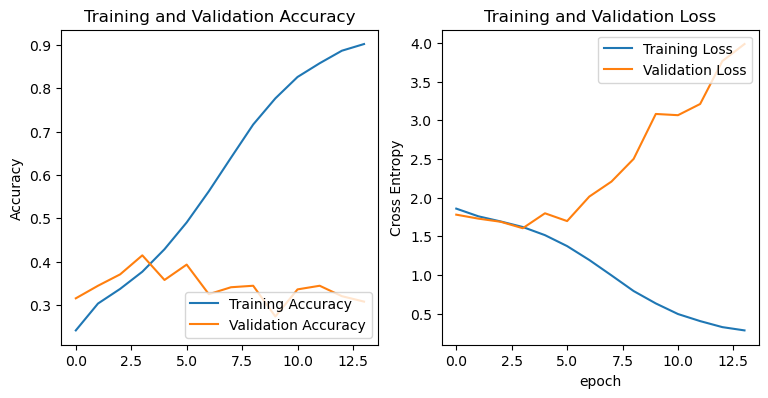

In [20]:
show_history_fit(history)

41/41 [==============================] - 5s 103ms/step - loss: 1.6032 - accuracy: 0.4092
tf.Tensor([6 5 1 ... 2 5 2], shape=(2622,), dtype=int64)
tf.Tensor([1 1 1 ... 2 5 5], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2761    0.1823    0.2196       203
           1     0.2594    0.2539    0.2566       382
           2     0.7162    0.5533    0.6243      1323
           3     0.0408    0.1176    0.0606        51
           4     0.0856    0.3014    0.1333        73
           5     0.2661    0.4460    0.3333       278
           6     0.2477    0.1763    0.2060       312

    accuracy                         0.4092      2622
   macro avg     0.2703    0.2901    0.2620      2622
weighted avg     0.4814    0.4092    0.4341      2622



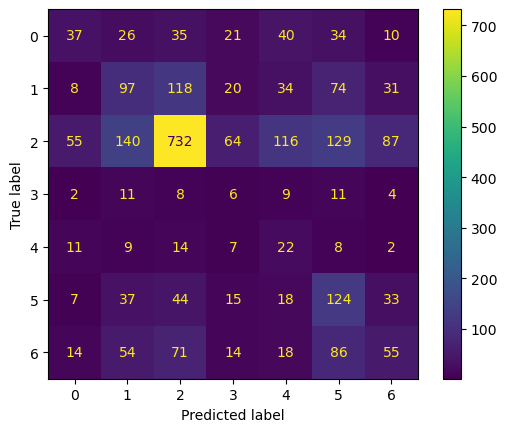

In [21]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 2 (37.91, overfitt dopo 7 epoche)

Add Dense Layer and Dropout

In [22]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu'))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(2048, (3, 3), activation='relu'))
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [23]:
compile_model(model, 'adam', 0.0001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                       

In [24]:
path_model = './multiclass_models_sc/ex2_scratch_32_2x256_512_dp_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=40, patience_par=10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.8665 - accuracy: 0.2353
Epoch 00001: val_loss improved from inf to 1.80892, saving model to ./multiclass_models_sc\ex2_scratch_32_2x256_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 58s 126ms/step - loss: 1.8665 - accuracy: 0.2353 - val_loss: 1.8089 - val_accuracy: 0.3013
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.7797 - accuracy: 0.2848
Epoch 00002: val_loss improved from 1.80892 to 1.75345, saving model to ./multiclass_models_sc\ex2_scratch_32_2x256_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 56s 126ms/step - loss: 1.7797 - accuracy: 0.2848 - val_loss: 1.7534 - val_accuracy: 0.3246
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.7283 - accuracy: 0.3161
Epoch 00003: val_loss improved from 1.75345 to 1.69903, saving model to ./multiclass_models_sc\ex2_scratch_32_2x256_512_dp_epoch_40_adam_1e-4.h5
438/438 [====

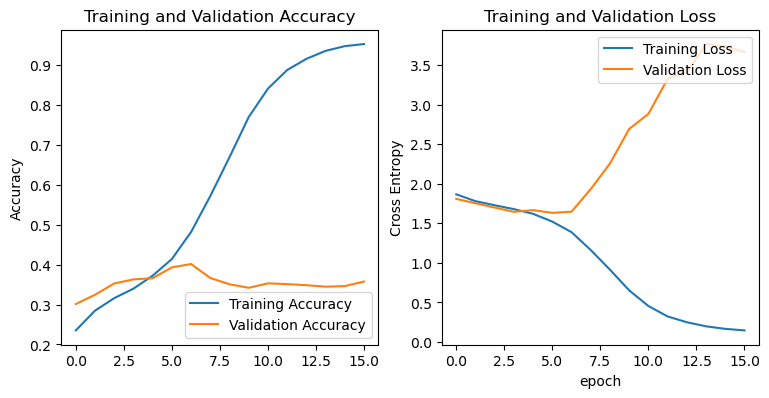

In [25]:
show_history_fit(history)

41/41 [==============================] - 5s 101ms/step - loss: 1.6467 - accuracy: 0.3791
tf.Tensor([0 2 5 ... 6 5 3], shape=(2622,), dtype=int64)
tf.Tensor([0 5 2 ... 1 6 0], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1950    0.3103    0.2395       203
           1     0.2839    0.2356    0.2575       382
           2     0.7406    0.4769    0.5802      1323
           3     0.0423    0.1765    0.0682        51
           4     0.0872    0.2603    0.1306        73
           5     0.2682    0.4101    0.3243       278
           6     0.2482    0.2179    0.2321       312

    accuracy                         0.3791      2622
   macro avg     0.2665    0.2982    0.2618      2622
weighted avg     0.4914    0.3791    0.4158      2622



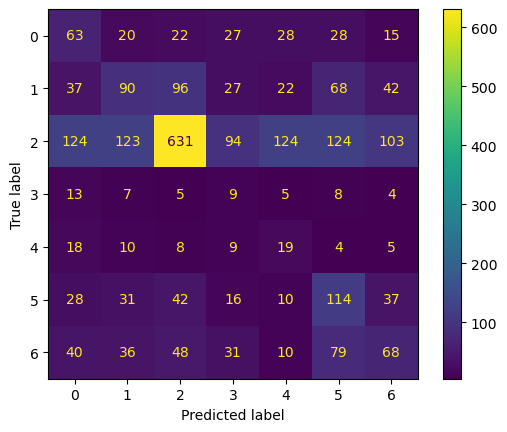

In [26]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 3 (40.96, overfit dopo 10 epoche)

More powerful Network

In [27]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [28]:
compile_model(model, 'adam', 0.0001)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                      

In [29]:
path_model = './multiclass_models_sc/ex3_scratch_32_2x256_1024_dp_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=40, patience_par=10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.8731 - accuracy: 0.2218
Epoch 00001: val_loss improved from inf to 1.80217, saving model to ./multiclass_models_sc\ex3_scratch_32_2x256_1024_dp_epoch_30_adam_1e-4.h5
438/438 [==============================] - 57s 128ms/step - loss: 1.8731 - accuracy: 0.2218 - val_loss: 1.8022 - val_accuracy: 0.2998
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.7837 - accuracy: 0.2889
Epoch 00002: val_loss improved from 1.80217 to 1.68488, saving model to ./multiclass_models_sc\ex3_scratch_32_2x256_1024_dp_epoch_30_adam_1e-4.h5
438/438 [==============================] - 57s 127ms/step - loss: 1.7837 - accuracy: 0.2889 - val_loss: 1.6849 - val_accuracy: 0.3593
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.7441 - accuracy: 0.3068
Epoch 00003: val_loss did not improve from 1.68488
438/438 [==============================] - 56s 126ms/step - loss: 1.7441 - accuracy: 0.3068 - val_loss: 1

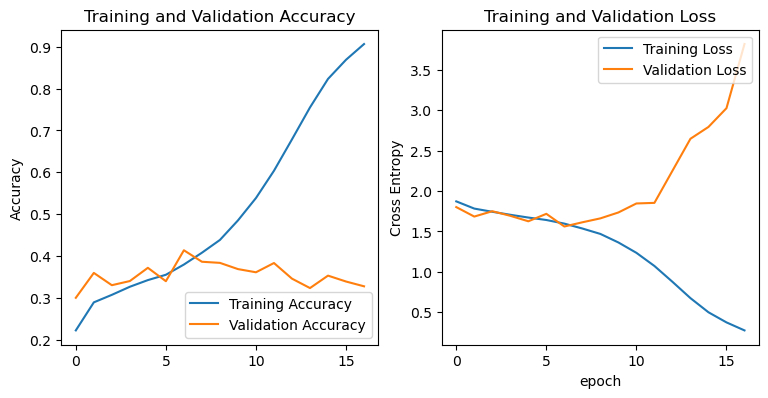

In [30]:
show_history_fit(history)

41/41 [==============================] - 5s 103ms/step - loss: 1.5541 - accuracy: 0.4096
tf.Tensor([1 5 5 ... 2 6 2], shape=(2622,), dtype=int64)
tf.Tensor([1 2 6 ... 5 2 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2514    0.2217    0.2356       203
           1     0.2779    0.2408    0.2581       382
           2     0.7533    0.5102    0.6084      1323
           3     0.0442    0.0980    0.0610        51
           4     0.1071    0.4110    0.1700        73
           5     0.2811    0.5036    0.3608       278
           6     0.2677    0.2788    0.2732       312

    accuracy                         0.4096      2622
   macro avg     0.2833    0.3235    0.2810      2622
weighted avg     0.5056    0.4096    0.4395      2622



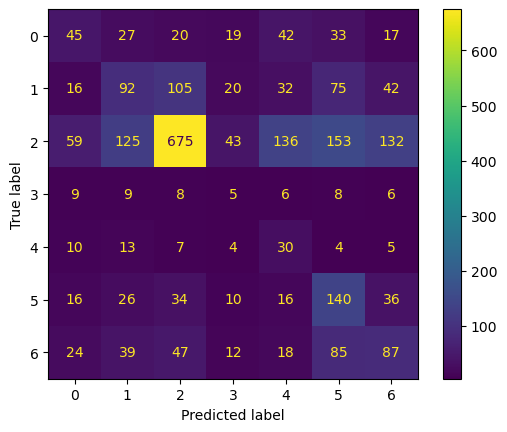

In [31]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 4 (39.59, overfit dopo 15 epoche) 

Insert GlobalAveragingPooling and Another dropout (to mitigate the overfit)

In [11]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [12]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                         

In [13]:
path_model = './multiclass_models_sc/ex4_scratch_32_2x256_1024_dpx2_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=40, patience_par=10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.9064 - accuracy: 0.1902
Epoch 00001: val_loss improved from inf to 1.95341, saving model to ./multiclass_models_sc\ex4_scratch_32_2x256_1024_dpx2_epoch_40_adam_1e-4.h5
438/438 [==============================] - 69s 140ms/step - loss: 1.9064 - accuracy: 0.1902 - val_loss: 1.9534 - val_accuracy: 0.2182
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.8238 - accuracy: 0.2512
Epoch 00002: val_loss improved from 1.95341 to 1.94349, saving model to ./multiclass_models_sc\ex4_scratch_32_2x256_1024_dpx2_epoch_40_adam_1e-4.h5
438/438 [==============================] - 60s 134ms/step - loss: 1.8238 - accuracy: 0.2512 - val_loss: 1.9435 - val_accuracy: 0.2227
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.7828 - accuracy: 0.2810
Epoch 00003: val_loss improved from 1.94349 to 1.71269, saving model to ./multiclass_models_sc\ex4_scratch_32_2x256_1024_dpx2_epoch_40_adam_1e-4.h5
438/

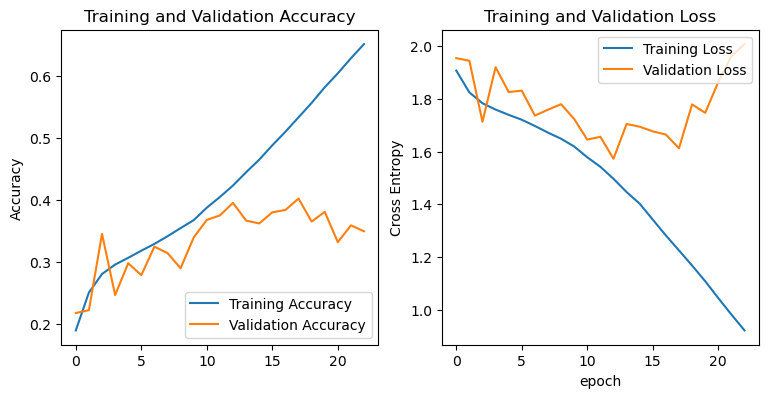

In [14]:
show_history_fit(history)

41/41 [==============================] - 5s 103ms/step - loss: 1.5764 - accuracy: 0.3959
tf.Tensor([2 5 2 ... 5 5 2], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2177    0.2660    0.2395       203
           1     0.2857    0.2356    0.2582       382
           2     0.7544    0.4807    0.5873      1323
           3     0.0567    0.1569    0.0833        51
           4     0.0969    0.3425    0.1511        73
           5     0.2896    0.4209    0.3431       278
           6     0.2615    0.3462    0.2979       312

    accuracy                         0.3959      2622
   macro avg     0.2804    0.3212    0.2801      2622
weighted avg     0.5048    0.3959    0.4301      2622



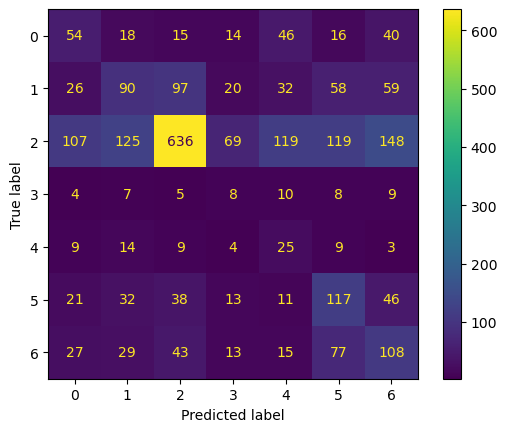

In [15]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 5 (40.92, andamento oscillatorio)

Dropout + Regularization (on Conv Layers)

In [16]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [17]:
compile_model(model, 'adam', 0.0001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                       

In [18]:
path_model = './multiclass_models_sc/ex5_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=40, patience_par=10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 2.2004 - accuracy: 0.2105
Epoch 00001: val_loss improved from inf to 1.95118, saving model to ./multiclass_models_sc\ex5_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-4.h5
438/438 [==============================] - 61s 135ms/step - loss: 2.2004 - accuracy: 0.2105 - val_loss: 1.9512 - val_accuracy: 0.2929
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.9161 - accuracy: 0.2566
Epoch 00002: val_loss improved from 1.95118 to 1.87890, saving model to ./multiclass_models_sc\ex5_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-4.h5
438/438 [==============================] - 60s 134ms/step - loss: 1.9161 - accuracy: 0.2566 - val_loss: 1.8789 - val_accuracy: 0.2876
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.8663 - accuracy: 0.2713
Epoch 00003: val_loss improved from 1.87890 to 1.87082, saving model to ./multiclass_models_sc\ex5_scratch_32_2x256_1024_dpx2_regula

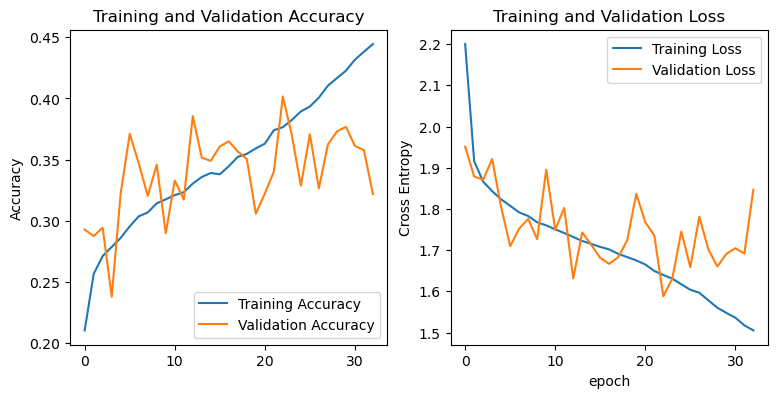

In [19]:
show_history_fit(history)

41/41 [==============================] - 11s 197ms/step - loss: 1.6006 - accuracy: 0.4062
tf.Tensor([6 5 1 ... 6 5 2], shape=(2622,), dtype=int64)
tf.Tensor([1 1 1 ... 2 5 5], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2345    0.3350    0.2759       203
           1     0.2857    0.1204    0.1694       382
           2     0.7240    0.5374    0.6169      1323
           3     0.0638    0.2941    0.1049        51
           4     0.1105    0.2603    0.1551        73
           5     0.4098    0.2698    0.3254       278
           6     0.2187    0.4199    0.2876       312

    accuracy                         0.4062      2622
   macro avg     0.2924    0.3196    0.2765      2622
weighted avg     0.4989    0.4062    0.4324      2622



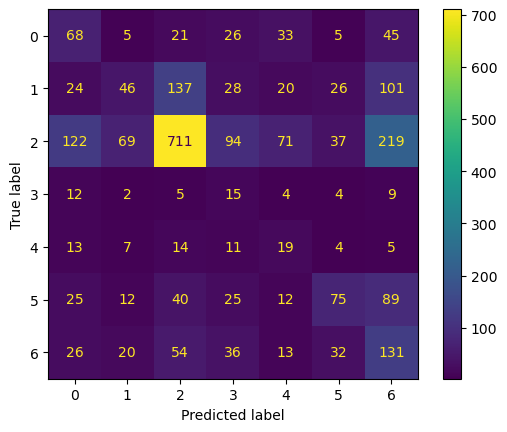

In [20]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 6 (DA ELIMINARE)

Remove some conv layers

In [21]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [22]:
compile_model(model, 'adam', 0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 120, 120, 128)     73856     
                                                           

In [23]:
path_model = './multiclass_models_sc/ex6_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=40, patience_par=10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 2.0627 - accuracy: 0.1434
Epoch 00001: val_loss improved from inf to 1.95724, saving model to ./multiclass_models_sc\ex6_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5
438/438 [==============================] - 151s 335ms/step - loss: 2.0627 - accuracy: 0.1434 - val_loss: 1.9572 - val_accuracy: 0.0992
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.9480 - accuracy: 0.1397
Epoch 00002: val_loss improved from 1.95724 to 1.94944, saving model to ./multiclass_models_sc\ex6_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5
438/438 [==============================] - 142s 321ms/step - loss: 1.9480 - accuracy: 0.1397 - val_loss: 1.9494 - val_accuracy: 0.0992
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.9463 - accuracy: 0.1394
Epoch 00003: val_loss improved from 1.94944 to 1.94590, saving model to ./multiclass_models_sc\ex6_scratch_32_

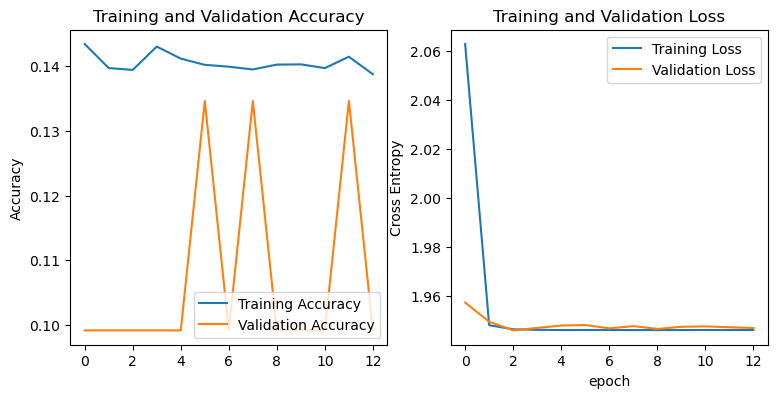

In [24]:
show_history_fit(history)

41/41 [==============================] - 11s 205ms/step - loss: 1.9455 - accuracy: 0.1060
tf.Tensor([5 5 5 ... 5 5 5], shape=(2622,), dtype=int64)
tf.Tensor([0 5 2 ... 1 6 0], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       203
           1     0.0000    0.0000    0.0000       382
           2     0.0000    0.0000    0.0000      1323
           3     0.0000    0.0000    0.0000        51
           4     0.0000    0.0000    0.0000        73
           5     0.1060    1.0000    0.1917       278
           6     0.0000    0.0000    0.0000       312

    accuracy                         0.1060      2622
   macro avg     0.0151    0.1429    0.0274      2622
weighted avg     0.0112    0.1060    0.0203      2622



c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


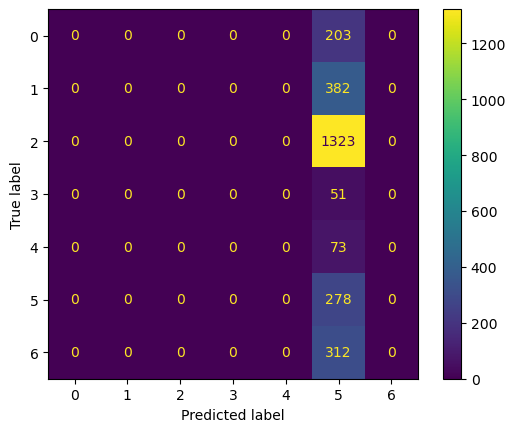

In [25]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 7 (34.67 dopo 10 epoche)

In [26]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [27]:
compile_model(model, 'adam', 0.0001)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                      

In [28]:
path_model = './multiclass_models_sc/ex7_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=40, patience_par=10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 3.4861 - accuracy: 0.2415
Epoch 00001: val_loss improved from inf to 3.43718, saving model to ./multiclass_models_sc\ex7_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_40_adam_1e-4.h5
438/438 [==============================] - 101s 222ms/step - loss: 3.4861 - accuracy: 0.2415 - val_loss: 3.4372 - val_accuracy: 0.1506
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 3.2025 - accuracy: 0.2788
Epoch 00002: val_loss improved from 3.43718 to 3.15180, saving model to ./multiclass_models_sc\ex7_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_40_adam_1e-4.h5
438/438 [==============================] - 99s 221ms/step - loss: 3.2025 - accuracy: 0.2788 - val_loss: 3.1518 - val_accuracy: 0.2689
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 2.9803 - accuracy: 0.2991
Epoch 00003: val_loss improved from 3.15180 to 2.88562, saving model to ./multiclass_models_sc\ex7_scratch_32_2

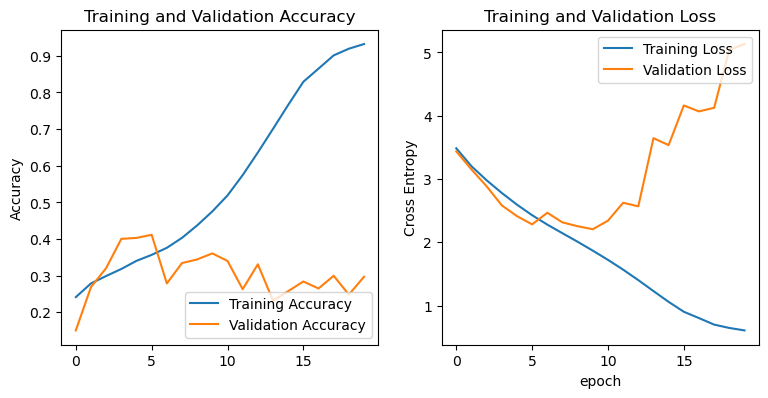

In [29]:
show_history_fit(history)

41/41 [==============================] - 5s 90ms/step - loss: 2.2025 - accuracy: 0.3463
tf.Tensor([1 4 5 ... 4 6 6], shape=(2622,), dtype=int64)
tf.Tensor([2 3 5 ... 1 2 6], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2244    0.2266    0.2255       203
           1     0.3095    0.1702    0.2196       382
           2     0.8056    0.3915    0.5270      1323
           3     0.0744    0.1765    0.1047        51
           4     0.0772    0.2877    0.1217        73
           5     0.2207    0.6906    0.3345       278
           6     0.1927    0.1859    0.1892       312

    accuracy                         0.3467      2622
   macro avg     0.2721    0.3041    0.2460      2622
weighted avg     0.5189    0.3467    0.3787      2622



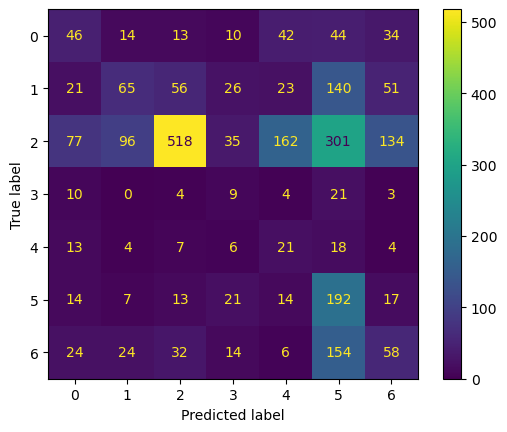

In [31]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 8 (41.84, dopo 6 epoche)

Provo la rete con 50 accuracy con regularization e altri metodi per mitigare l'overfitting

In [32]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [33]:
compile_model(model, 'adam', 0.0001)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                      

In [35]:
path_model = './multiclass_models_sc/ex8_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=40, patience_par=10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 6.2960 - accuracy: 0.2750
Epoch 00001: val_loss improved from inf to 4.02434, saving model to ./multiclass_models_sc\ex8_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5
438/438 [==============================] - 61s 135ms/step - loss: 6.2960 - accuracy: 0.2750 - val_loss: 4.0243 - val_accuracy: 0.4531
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 3.4201 - accuracy: 0.3024
Epoch 00002: val_loss improved from 4.02434 to 2.76586, saving model to ./multiclass_models_sc\ex8_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5
438/438 [==============================] - 61s 137ms/step - loss: 3.4201 - accuracy: 0.3024 - val_loss: 2.7659 - val_accuracy: 0.3490
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 2.5157 - accuracy: 0.3271
Epoch 00003: val_loss improved from 2.76586 to 2.24786, saving model to ./multiclass_models_sc\ex8_scratch_32_2x256_512_dp

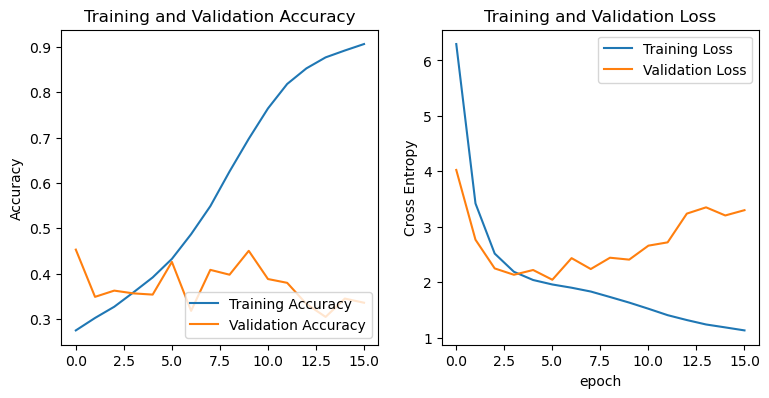

In [36]:
show_history_fit(history)

41/41 [==============================] - 6s 106ms/step - loss: 2.0406 - accuracy: 0.4184
tf.Tensor([1 2 2 ... 0 2 4], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 3 6 6], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2938    0.2315    0.2590       203
           1     0.2812    0.2775    0.2793       382
           2     0.7538    0.5231    0.6176      1323
           3     0.0674    0.2353    0.1048        51
           4     0.1020    0.1370    0.1170        73
           5     0.2840    0.5180    0.3669       278
           6     0.2240    0.2756    0.2471       312

    accuracy                         0.4184      2622
   macro avg     0.2866    0.3140    0.2845      2622
weighted avg     0.5050    0.4184    0.4460      2622



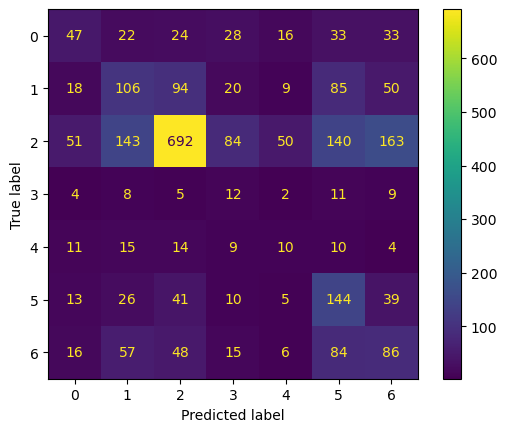

In [37]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 9 (46.26, NON HO IL GRAFICO)

Provo la rete dell'esperimento 7 con una regularization diversa e un parametro di regolatization differente

In [11]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.001))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [12]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 115, 115, 128)     73856     
                                                             

In [11]:
path_model = './multiclass_models_sc/ex9_scratch_32_2x256_512_1024_dp_regularL1_batchnorm_epoch_35_adam_1e-4.h5'
#history, model_fitted = fit_model(model, train_ds, val_ds, path_model, 40, 10) #240x240

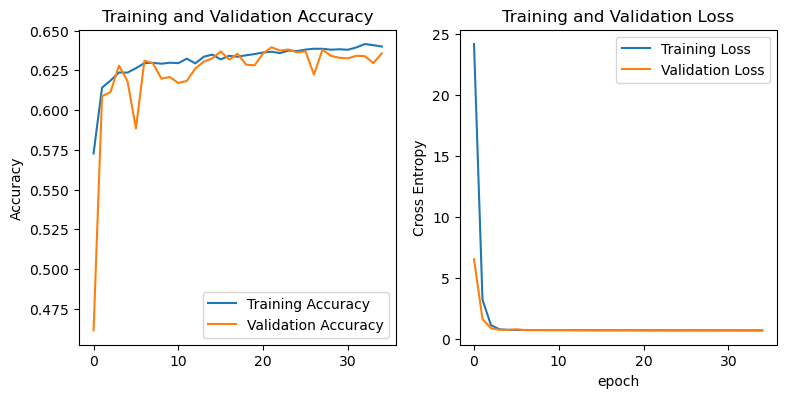

In [ ]:
show_history_fit(history)

41/41 [==============================] - 18s 272ms/step - loss: 1.5819 - accuracy: 0.4626
tf.Tensor([2 5 2 ... 5 5 2], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.4138    0.1182    0.1839       203
           1     0.3198    0.2068    0.2512       382
           2     0.6640    0.6780    0.6709      1323
           3     0.1200    0.0588    0.0789        51
           4     0.1408    0.2740    0.1860        73
           5     0.2402    0.5540    0.3351       278
           6     0.2278    0.1154    0.1532       312

    accuracy                         0.4626      2622
   macro avg     0.3038    0.2865    0.2656      2622
weighted avg     0.4725    0.4626    0.4498      2622



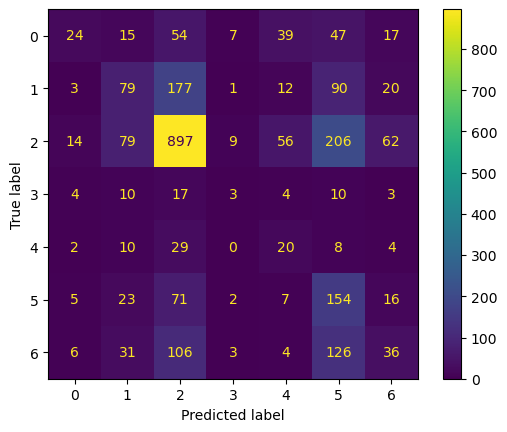

In [12]:
load_best_model_and_evaluate(path_model, test_ds)

Provare ad allenare la rete dell'esperimento 8 però con una patience manggiore per vedere se la rete riesce a migliorare o a trovare una mappatura maggiore

### Experiment 10 (39.47, dopo 6 epoche)

In [ ]:
#clear from the previuos training
#from tensorflow.keras import backend as K
#del model
#K.clear_session()

In [11]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [12]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                         

In [13]:
path_model = './multiclass_models_sc/ex10_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, 35, 10) #250

Epoch 1/35
438/438 [==============================] - ETA: 0s - loss: 9.7140 - accuracy: 0.2521
Epoch 00001: val_loss improved from inf to 6.24179, saving model to ./multiclass_models_sc\ex10_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5
438/438 [==============================] - 104s 218ms/step - loss: 9.7140 - accuracy: 0.2521 - val_loss: 6.2418 - val_accuracy: 0.1320
Epoch 2/35
438/438 [==============================] - ETA: 0s - loss: 4.2259 - accuracy: 0.2984
Epoch 00002: val_loss improved from 6.24179 to 3.10490, saving model to ./multiclass_models_sc\ex10_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5
438/438 [==============================] - 94s 213ms/step - loss: 4.2259 - accuracy: 0.2984 - val_loss: 3.1049 - val_accuracy: 0.3928
Epoch 3/35
438/438 [==============================] - ETA: 0s - loss: 2.8022 - accuracy: 0.3340
Epoch 00003: val_loss improved from 3.10490 to 2.56299, saving model to ./multiclass_models_sc\ex10_scratch_32_2x256_51

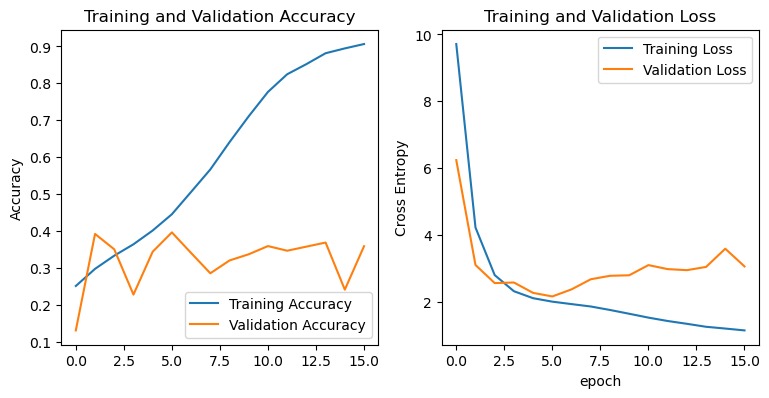

In [14]:
show_history_fit(history)

41/41 [==============================] - 7s 134ms/step - loss: 2.1626 - accuracy: 0.3947
tf.Tensor([2 5 2 ... 5 5 2], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2984    0.1823    0.2263       203
           1     0.3636    0.1257    0.1868       382
           2     0.7367    0.5034    0.5981      1323
           3     0.0444    0.1176    0.0645        51
           4     0.0901    0.3973    0.1468        73
           5     0.3375    0.3885    0.3612       278
           6     0.2058    0.4519    0.2828       312

    accuracy                         0.3947      2622
   macro avg     0.2967    0.3095    0.2667      2622
weighted avg     0.5115    0.3947    0.4238      2622



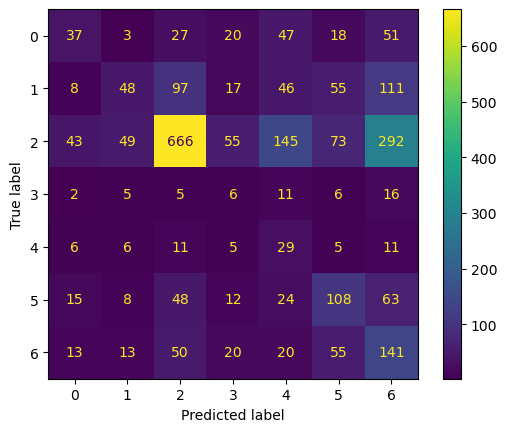

In [15]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 11 (36.08, andamento discreto ma migliora lentamente)

Esperimenti vari

In [16]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
#x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [17]:
compile_model(model, 'adam', 0.00001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                       

In [18]:
path_model = './multiclass_models_sc/ex11_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-5.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 8.0992 - accuracy: 0.1678
Epoch 00001: val_loss improved from inf to 6.81677, saving model to ./multiclass_models_sc\ex11_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-5.h5
438/438 [==============================] - 105s 233ms/step - loss: 8.0992 - accuracy: 0.1678 - val_loss: 6.8168 - val_accuracy: 0.3089
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 5.8654 - accuracy: 0.2110
Epoch 00002: val_loss improved from 6.81677 to 5.05826, saving model to ./multiclass_models_sc\ex11_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-5.h5
438/438 [==============================] - 78s 177ms/step - loss: 5.8654 - accuracy: 0.2110 - val_loss: 5.0583 - val_accuracy: 0.2830
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 4.5347 - accuracy: 0.2383
Epoch 00003: val_loss improved from 5.05826 to 4.07341, saving model to ./multiclass_models_sc\ex11_scratch_32_2x256_1024_dpx2_re

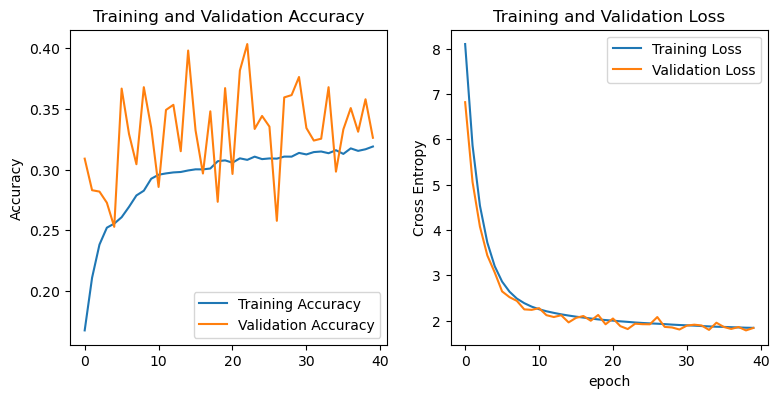

In [19]:
show_history_fit(history)

41/41 [==============================] - 6s 103ms/step - loss: 1.7893 - accuracy: 0.3608
tf.Tensor([6 5 1 ... 6 5 2], shape=(2622,), dtype=int64)
tf.Tensor([1 1 1 ... 2 5 5], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3143    0.1084    0.1612       203
           1     0.2216    0.1937    0.2067       382
           2     0.7458    0.4346    0.5492      1323
           3     0.0543    0.2353    0.0882        51
           4     0.1009    0.3014    0.1512        73
           5     0.2659    0.5108    0.3498       278
           6     0.2089    0.3173    0.2519       312

    accuracy                         0.3608      2622
   macro avg     0.2731    0.3002    0.2512      2622
weighted avg     0.4898    0.3608    0.3927      2622



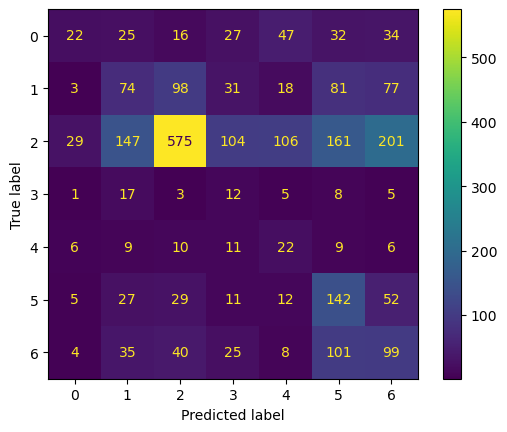

In [20]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 12 (41.42, andamento troppo altalenante)

Uso rete esperimento 4 con aggiunta di un layer di batch normalizzation e regularization e un  dense layer in più

In [21]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (5, 5), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (4, 4), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L1L2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [22]:
compile_model(model, 'adam', 0.0001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 246, 246, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 120, 120, 64)      32832     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                       

In [23]:
path_model = './multiclass_models_sc/ex12_scratch_32_2x256_1024_dpx2_regulariz_batch_moreDense_epoch_30_adam_1e-5.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 21.6796 - accuracy: 0.2358
Epoch 00001: val_loss improved from inf to 2.02174, saving model to ./multiclass_models_sc\ex12_scratch_32_2x256_1024_dpx2_regulariz_batch_moreDense_epoch_30_adam_1e-5.h5
438/438 [==============================] - 65s 143ms/step - loss: 21.6796 - accuracy: 0.2358 - val_loss: 2.0217 - val_accuracy: 0.2723
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.9073 - accuracy: 0.2653
Epoch 00002: val_loss improved from 2.02174 to 1.79094, saving model to ./multiclass_models_sc\ex12_scratch_32_2x256_1024_dpx2_regulariz_batch_moreDense_epoch_30_adam_1e-5.h5
438/438 [==============================] - 62s 140ms/step - loss: 1.9073 - accuracy: 0.2653 - val_loss: 1.7909 - val_accuracy: 0.3322
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.8462 - accuracy: 0.2780
Epoch 00003: val_loss did not improve from 1.79094
438/438 [==============================] - 62

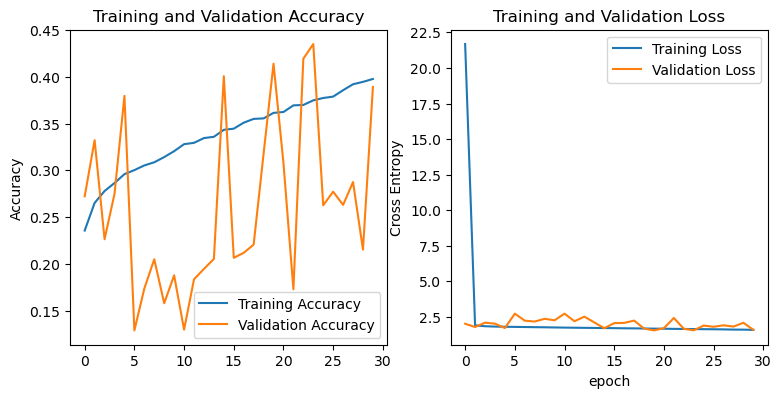

In [24]:
show_history_fit(history)

41/41 [==============================] - 5s 102ms/step - loss: 1.5418 - accuracy: 0.4142
tf.Tensor([5 2 5 ... 5 5 2], shape=(2622,), dtype=int64)
tf.Tensor([0 5 2 ... 1 6 0], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3611    0.0640    0.1088       203
           1     0.2478    0.2199    0.2330       382
           2     0.7118    0.5525    0.6221      1323
           3     0.3125    0.0980    0.1493        51
           4     0.1111    0.1507    0.1279        73
           5     0.2225    0.6763    0.3348       278
           6     0.2077    0.1731    0.1888       312

    accuracy                         0.4142      2622
   macro avg     0.3106    0.2764    0.2521      2622
weighted avg     0.4807    0.4142    0.4207      2622



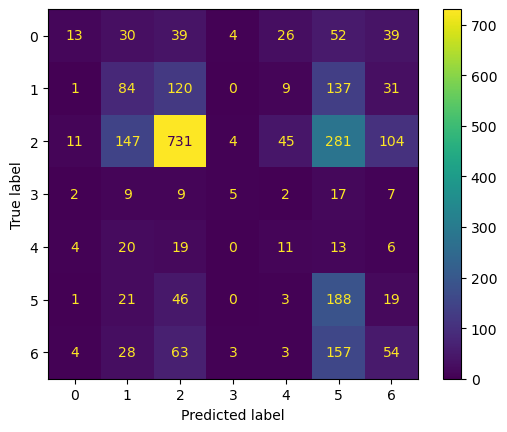

In [25]:
load_best_model_and_evaluate(path_model, test_ds)

## Riassunto Scratch 

Riassunto delle reti from scratch fino ad adesso: Le reti soffrono di overfitting, probabilmente poichè non riescono a generalizzare in maniera adeguata. Le reti non troppo grandi hanno dato dei risultati discreti con un buon andamento di apprendimento se inserito un layer di Regularization insieme a quello di dropout. Quello che si vuole tentare di fare adesso è creare delle reti che non sono molto grandi, in quanto abbiamo visto che reti più profonde non riescono a dare risultati più soddisfacenti. Quindi ci concentreremo su reti più piccole, anche secondo il paper letto, ma con configurazioni differenti.

## Altre Prove: Scratch 2 (Provo con Reti piccole + Reti con configurazioni lette un paper)

### Experiment 1_bis: provo con un rete piccola ma diversi filtri di partenza (non buono e non bilanciato, 36.54 dopo 5 epoche)

In [11]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.3)(x)
#x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.4)(x)
#x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [12]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                             

In [13]:
path_model = './multiclass_models_sc/ex1_bis_scratchv2_32_2x256_35_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10) #200x200

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.8486 - accuracy: 0.2430
Epoch 00001: val_loss improved from inf to 1.85989, saving model to ./multiclass_models_sc\ex1_bis_scratchv2_32_2x256_35_adam_1e-4.h5
438/438 [==============================] - 160s 347ms/step - loss: 1.8486 - accuracy: 0.2430 - val_loss: 1.8599 - val_accuracy: 0.3009
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.7467 - accuracy: 0.3070
Epoch 00002: val_loss improved from 1.85989 to 1.67910, saving model to ./multiclass_models_sc\ex1_bis_scratchv2_32_2x256_35_adam_1e-4.h5
438/438 [==============================] - 150s 340ms/step - loss: 1.7467 - accuracy: 0.3070 - val_loss: 1.6791 - val_accuracy: 0.3688
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.6844 - accuracy: 0.3420
Epoch 00003: val_loss did not improve from 1.67910
438/438 [==============================] - 150s 340ms/step - loss: 1.6844 - accuracy: 0.3420 - val_loss: 1.7725 - val_a

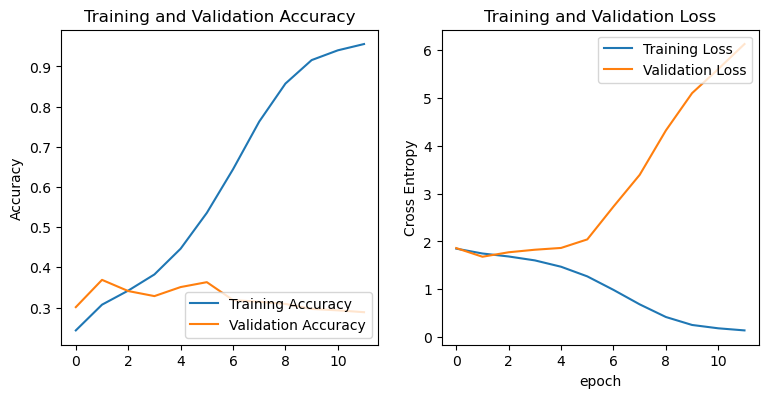

In [14]:
show_history_fit(history)

41/41 [==============================] - 6s 120ms/step - loss: 1.6961 - accuracy: 0.3654
tf.Tensor([2 5 2 ... 5 5 2], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1639    0.4778    0.2440       203
           1     0.2629    0.1466    0.1882       382
           2     0.7150    0.4626    0.5617      1323
           3     0.0526    0.0980    0.0685        51
           4     0.0920    0.3151    0.1424        73
           5     0.2769    0.4353    0.3385       278
           6     0.2458    0.1410    0.1792       312

    accuracy                         0.3654      2622
   macro avg     0.2584    0.2966    0.2461      2622
weighted avg     0.4739    0.3654    0.3923      2622



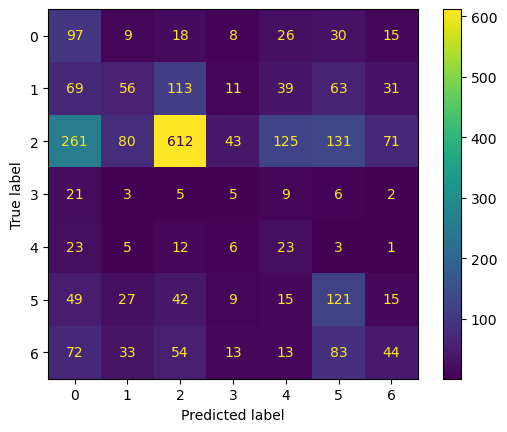

In [15]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 2_bis: provo con un rete A-CNN, 36.84 dopo 5 epoche -- 40.26 seconda prova

In [16]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(1000, activation='relu')(x)
#x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)


#model = keras.models.Sequential([
#    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
#    keras.layers.BatchNormalization(),
#    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#   keras.layers.BatchNormalization(),
#  keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#   # keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#    keras.layers.BatchNormalization(),
#    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#    keras.layers.BatchNormalization(),
#    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#    keras.layers.BatchNormalization(),
#    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    keras.layers.Flatten(),
#    keras.layers.Dense(4096, activation='relu'),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(4096, activation='relu'),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(10, activation='softmax')
#])


In [17]:
compile_model(model, 'adam', 0.0001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 96)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 256)       6146

In [18]:
path_model = './multiclass_models_sc/ex2_bis_scratchv2_alex_4ly_35_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.8500 - accuracy: 0.2691
Epoch 00001: val_loss improved from inf to 1.93489, saving model to ./multiclass_models_sc\ex2_bis_scratchv2_alex_4ly_35_adam_1e-4.h5
438/438 [==============================] - 53s 116ms/step - loss: 1.8500 - accuracy: 0.2691 - val_loss: 1.9349 - val_accuracy: 0.2243
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.7211 - accuracy: 0.3220
Epoch 00002: val_loss did not improve from 1.93489
438/438 [==============================] - 51s 114ms/step - loss: 1.7211 - accuracy: 0.3220 - val_loss: 1.9354 - val_accuracy: 0.2674
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.6415 - accuracy: 0.3607
Epoch 00003: val_loss improved from 1.93489 to 1.84101, saving model to ./multiclass_models_sc\ex2_bis_scratchv2_alex_4ly_35_adam_1e-4.h5
438/438 [==============================] - 50s 113ms/step - loss: 1.6415 - accuracy: 0.3607 - val_loss: 1.8410 - val_accu

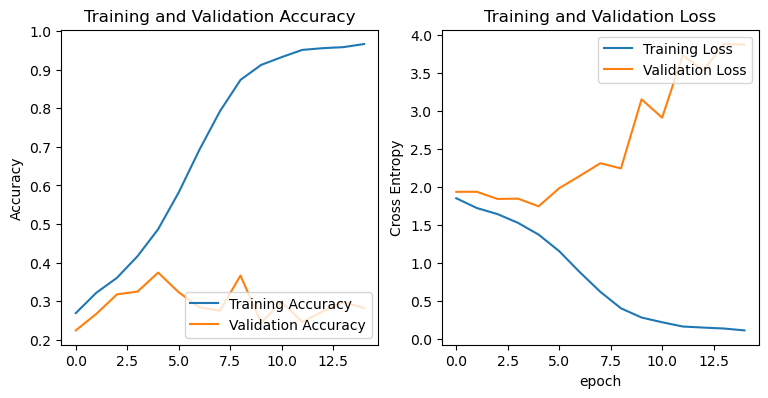

In [19]:
show_history_fit(history)

41/41 [==============================] - 5s 94ms/step - loss: 1.7393 - accuracy: 0.3684
tf.Tensor([6 1 1 ... 6 5 2], shape=(2622,), dtype=int64)
tf.Tensor([1 1 1 ... 2 5 5], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.4286    0.0296    0.0553       203
           1     0.2017    0.3770    0.2628       382
           2     0.7468    0.4437    0.5567      1323
           3     0.0385    0.0196    0.0260        51
           4     0.1145    0.2603    0.1590        73
           5     0.2432    0.4532    0.3166       278
           6     0.2085    0.2660    0.2338       312

    accuracy                         0.3684      2622
   macro avg     0.2831    0.2642    0.2300      2622
weighted avg     0.4939    0.3684    0.3898      2622



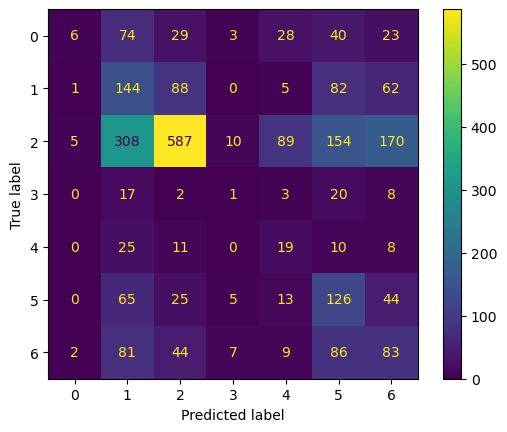

In [20]:
load_best_model_and_evaluate(path_model, test_ds)

In [21]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [22]:
compile_model(model, 'adam', 0.0001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 96)        34944     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 23, 23, 256)       6146

In [23]:
path_model = './multiclass_models_sc/ex2_bis_dropout_scratchv2_alex_4ly_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.9321 - accuracy: 0.2267
Epoch 00001: val_loss improved from inf to 1.88515, saving model to ./multiclass_models_sc\ex2_bis_dropout_scratchv2_alex_4ly_40_adam_1e-4.h5
438/438 [==============================] - 50s 112ms/step - loss: 1.9321 - accuracy: 0.2267 - val_loss: 1.8852 - val_accuracy: 0.2494
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.8432 - accuracy: 0.2516
Epoch 00002: val_loss did not improve from 1.88515
438/438 [==============================] - 50s 111ms/step - loss: 1.8432 - accuracy: 0.2516 - val_loss: 2.0560 - val_accuracy: 0.1335
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.8158 - accuracy: 0.2678
Epoch 00003: val_loss improved from 1.88515 to 1.76343, saving model to ./multiclass_models_sc\ex2_bis_dropout_scratchv2_alex_4ly_40_adam_1e-4.h5
438/438 [==============================] - 50s 113ms/step - loss: 1.8158 - accuracy: 0.2678 - val_loss: 1

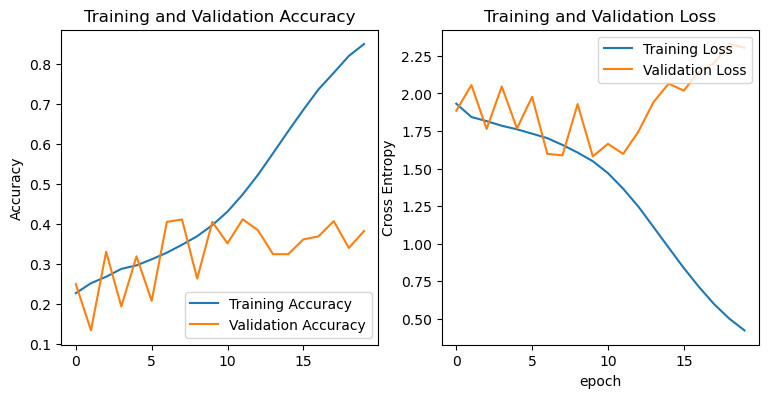

In [24]:
show_history_fit(history)

41/41 [==============================] - 5s 92ms/step - loss: 1.5885 - accuracy: 0.4027
tf.Tensor([2 2 5 ... 6 5 4], shape=(2622,), dtype=int64)
tf.Tensor([0 5 2 ... 1 6 0], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2390    0.1872    0.2099       203
           1     0.2623    0.2932    0.2769       382
           2     0.6682    0.5616    0.6103      1323
           3     0.0351    0.0784    0.0485        51
           4     0.0847    0.4110    0.1405        73
           5     0.3349    0.2554    0.2898       278
           6     0.2377    0.1859    0.2086       312

    accuracy                         0.4027      2622
   macro avg     0.2660    0.2818    0.2549      2622
weighted avg     0.4607    0.4027    0.4249      2622



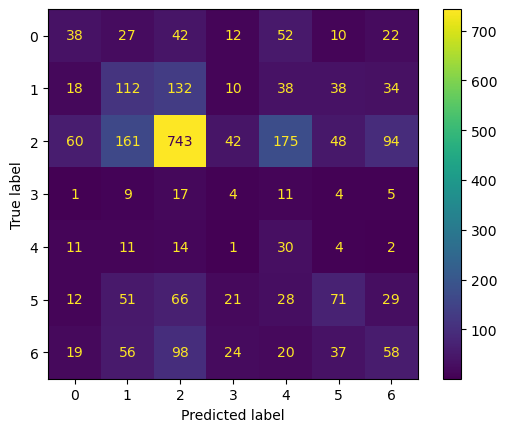

In [25]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 3_bis: Provo con un rete che prende e unisce l'output da più livelli (31.25 dopo 5 epoche)

In [11]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
l1 = layers.Rescaling(1./255)(input)
l1 = layers.Conv2D(filters=128, kernel_size=(11,11), activation='relu')(l1) #, strides=(4,4)
l1 = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l1)
l1 = layers.MaxPool2D(pool_size=(3,3))(l1)

l1_out = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l1)
l1_out = layers.GlobalAveragePooling2D()(l1_out)
l1_out = layers.Dense(512, activation='relu')(l1_out)
l1_out = layers.Dense(256, activation='relu')(l1_out)

l2 = layers.Conv2D(filters=256, kernel_size=(5,5), activation='relu')(l1)
l2 = layers.Conv2D(filters=256, kernel_size=(1,1), activation='relu')(l2)
l2 = layers.MaxPool2D(pool_size=(3,3))(l2)

l2_out = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l2)
l2_out = layers.GlobalAveragePooling2D()(l2_out)
l2_out = layers.Dense(512, activation='relu')(l2_out)
l2_out = layers.Dense(256, activation='relu')(l2_out)

l3 = layers.Conv2D(filters=384, kernel_size=(5,5), activation='relu')(l2)
l3 = layers.Conv2D(filters=384, kernel_size=(1,1), activation='relu')(l3)
l3 = layers.MaxPool2D(pool_size=(3,3))(l3)

l3_out = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l3)
l3_out = layers.GlobalAveragePooling2D()(l3_out)
l3_out = layers.Dense(512, activation='relu')(l3_out)
l3_out = layers.Dense(256, activation='relu')(l3_out)

l4 = layers.Conv2D(filters=512, kernel_size=(5,5), activation='relu')(l3)
l4 = layers.Conv2D(filters=512, kernel_size=(1,1), activation='relu')(l4)
l4 = layers.MaxPool2D(pool_size=(3,3))(l4)

l4_out = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l4)
l4_out = layers.GlobalAveragePooling2D()(l4_out)
l4_out = layers.Dense(512, activation='relu')(l4_out)
l4_out = layers.Dense(256, activation='relu')(l4_out)
#print(l1_out.shape, l2_out.shape, l3_out.shape, l4_out.shape)

merge = layers.Average()([l1_out, l2_out, l3_out, l4_out])

output = layers.Dense(NUM_CLASSES, activation='softmax')(merge)

model = tf.keras.Model(inputs=input, outputs = output)

In [12]:
#tf.keras.utils.plot_model(model)

In [13]:
compile_model(model, 'adam', 0.0001)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 12  46592       ['rescaling[0][0]']              
                                8)                                                                
                                                                                              

In [15]:
path_model = './extra_multiclass_models_sc/7_dropout_scratchv2_alex_middleinfo_35_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,35,10) #300x300  batch 12

Epoch 1/35
1556/1556 [==============================] - ETA: 0s - loss: 1.9206 - accuracy: 0.1809
Epoch 00001: val_loss improved from inf to 1.88904, saving model to ./extra_multiclass_models_sc\7_dropout_scratchv2_alex_middleinfo_35_adam_1e-4.h5
1556/1556 [==============================] - 231s 148ms/step - loss: 1.9206 - accuracy: 0.1809 - val_loss: 1.8890 - val_accuracy: 0.2822


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/35
1556/1556 [==============================] - ETA: 0s - loss: 1.8120 - accuracy: 0.2674
Epoch 00002: val_loss improved from 1.88904 to 1.81851, saving model to ./extra_multiclass_models_sc\7_dropout_scratchv2_alex_middleinfo_35_adam_1e-4.h5
1556/1556 [==============================] - 225s 145ms/step - loss: 1.8120 - accuracy: 0.2674 - val_loss: 1.8185 - val_accuracy: 0.2941
Epoch 3/35
1556/1556 [==============================] - ETA: 0s - loss: 1.7737 - accuracy: 0.2881
Epoch 00003: val_loss improved from 1.81851 to 1.78338, saving model to ./extra_multiclass_models_sc\7_dropout_scratchv2_alex_middleinfo_35_adam_1e-4.h5
1556/1556 [==============================] - 226s 145ms/step - loss: 1.7737 - accuracy: 0.2881 - val_loss: 1.7834 - val_accuracy: 0.3131
Epoch 4/35
1556/1556 [==============================] - ETA: 0s - loss: 1.7481 - accuracy: 0.3037
Epoch 00004: val_loss improved from 1.78338 to 1.75903, saving model to ./extra_multiclass_models_sc\7_dropout_scratchv2_alex_

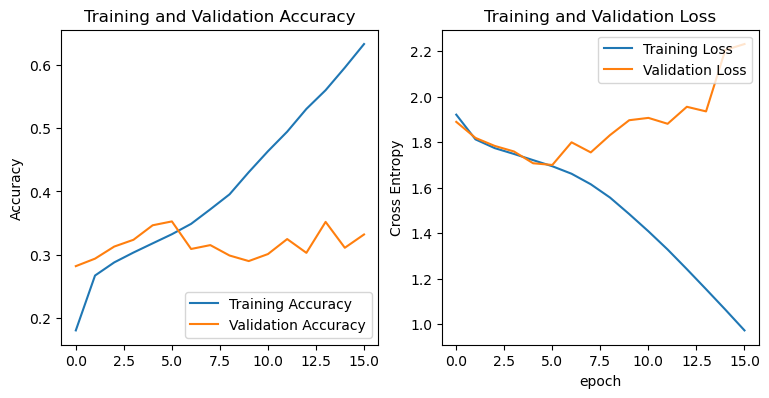

In [16]:
show_history_fit(history)

146/146 [==============================] - 8s 54ms/step - loss: 1.7146 - accuracy: 0.3455
tf.Tensor([5 5 4 ... 5 5 5], shape=(2622,), dtype=int64)
tf.Tensor([2 5 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2326    0.2463    0.2392       203
           1     0.2462    0.1283    0.1687       382
           2     0.7560    0.4051    0.5276      1323
           3     0.0476    0.1569    0.0731        51
           4     0.0893    0.4110    0.1467        73
           5     0.2346    0.6007    0.3374       278
           6     0.2332    0.2115    0.2218       312

    accuracy                         0.3455      2622
   macro avg     0.2628    0.3085    0.2449      2622
weighted avg     0.4914    0.3455    0.3770      2622



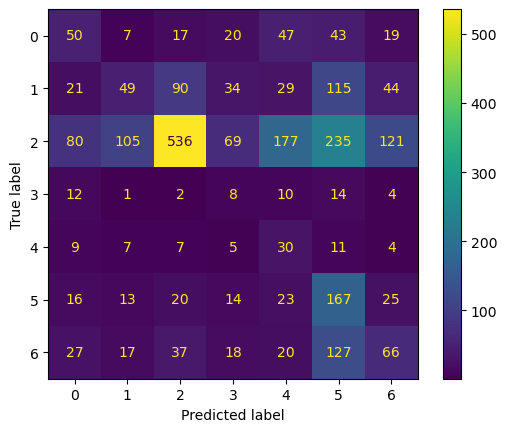

In [17]:
load_best_model_and_evaluate(path_model, test_ds)

## Commento Scratch 2
Non ci sono stati particolari miglioramenti con l'utilizzo di queste reti viste nel paper, più o meno le performance sono quelle viste con le reti implementate prima, anzi in alcune reti precedenti ci sono delle reti che performano leggermente meglio

## Pre-Trained Networks

### VGG16

#### Experiment 1 (48.47 dopo 5 epoche)

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
        weights='imagenet',  # load the network pretrained on ImageNet1K
        include_top=False)
        
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
LR = 0.0001
compile_model(model, 'adam', LR)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 250, 250, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 250, 250, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [ ]:
path_model = './multiclass_models_sc/pretrained_vgg16_no_tuning_512_dp_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 2.7513 - accuracy: 0.2902
Epoch 00001: val_loss improved from inf to 1.71734, saving model to ./multiclass_models_sc\pretrained_vgg16_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 121s 255ms/step - loss: 2.7513 - accuracy: 0.2902 - val_loss: 1.7173 - val_accuracy: 0.4119
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.7650 - accuracy: 0.3705
Epoch 00002: val_loss improved from 1.71734 to 1.56554, saving model to ./multiclass_models_sc\pretrained_vgg16_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 107s 241ms/step - loss: 1.7650 - accuracy: 0.3705 - val_loss: 1.5655 - val_accuracy: 0.4287
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.5765 - accuracy: 0.4138
Epoch 00003: val_loss improved from 1.56554 to 1.50556, saving model to ./multiclass_models_sc\pretrained_vgg16_no_tuning_512_dp_epoch_40_adam_1

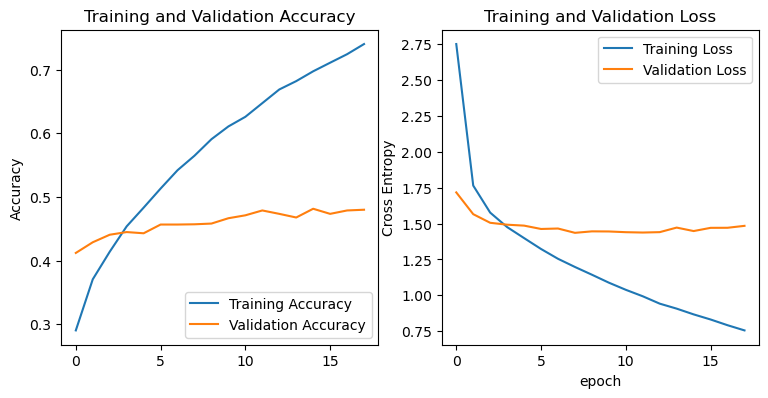

In [ ]:
show_history_fit(history)

41/41 [==============================] - 13s 233ms/step - loss: 1.4295 - accuracy: 0.4847
tf.Tensor([2 6 2 ... 5 6 1], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3193    0.4483    0.3730       203
           1     0.3741    0.4084    0.3905       382
           2     0.8418    0.5389    0.6571      1323
           3     0.1905    0.3137    0.2370        51
           4     0.1056    0.2329    0.1453        73
           5     0.3341    0.5108    0.4040       278
           6     0.3375    0.4359    0.3804       312

    accuracy                         0.4847      2622
   macro avg     0.3575    0.4127    0.3696      2622
weighted avg     0.5862    0.4847    0.5141      2622



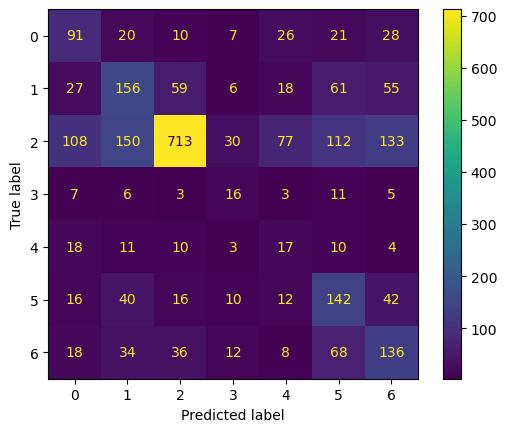

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

#### Experiment 2 (49.62 dopo 2 epoche)

In [ ]:
model_finetune = tf.keras.models.load_model(path_model)
model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 250, 250, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 250, 250, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [ ]:
model_finetune.trainable = True

base_model_vgg16 = model_finetune.get_layer("vgg16") # change the name looking at the summary IMPORTANT!
print("Number of layers in the base model: ", len(base_model_vgg16.layers))
base_model_vgg16.summary()

Number of layers in the base model:  19
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPool

In [ ]:
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1': # è buona pratica indicare da dove si parte a sfreezare la rete
        set_trainable = True
    if set_trainable: # fine a che la variabile booleana è a False allora setto i layer non traininabili altrimenti li setto come trainabili
        layer.trainable = True
    else:
        layer.trainable = False



model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 250, 250, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 250, 250, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [ ]:
compile_model(model_finetune, 'adam', LR)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 250, 250, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 250, 250, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [ ]:
path_model_tuned = './multiclass_models_sc/pretrained_vgg16_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5'
history_tune, model_fitted_tuned = fit_model(model_finetune, train_ds, val_ds, path_model_tuned,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.4504 - accuracy: 0.4609
Epoch 00001: val_loss improved from inf to 1.35848, saving model to ./multiclass_models_sc\pretrained_vgg16_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 118s 260ms/step - loss: 1.4504 - accuracy: 0.4609 - val_loss: 1.3585 - val_accuracy: 0.4920
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.5760
Epoch 00002: val_loss did not improve from 1.35848
438/438 [==============================] - 114s 258ms/step - loss: 1.1481 - accuracy: 0.5760 - val_loss: 1.3704 - val_accuracy: 0.4943
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.6708
Epoch 00003: val_loss did not improve from 1.35848
438/438 [==============================] - 113s 256ms/step - loss: 0.8971 - accuracy: 0.6708 - val_loss: 1.5426 - val_accuracy: 0.4924
Epoch 4/40
438/438 [=======================

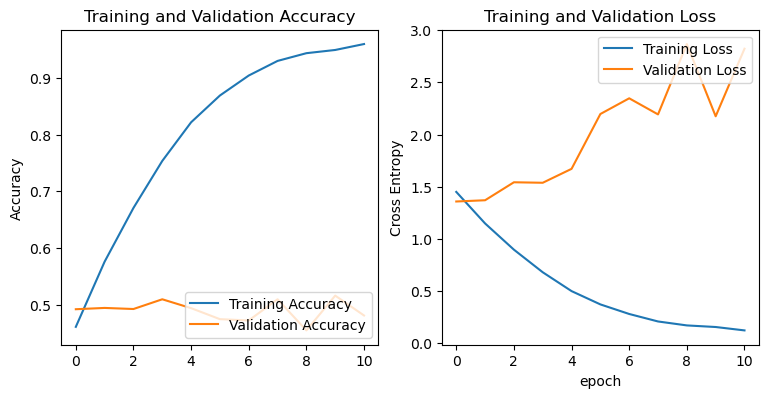

In [ ]:
show_history_fit(history_tune)

41/41 [==============================] - 10s 212ms/step - loss: 1.3724 - accuracy: 0.4966
tf.Tensor([6 5 1 ... 2 5 5], shape=(2622,), dtype=int64)
tf.Tensor([1 1 1 ... 2 5 5], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3348    0.3842    0.3578       203
           1     0.4532    0.3927    0.4208       382
           2     0.8410    0.5639    0.6751      1323
           3     0.2045    0.3529    0.2590        51
           4     0.1071    0.2466    0.1494        73
           5     0.3536    0.5432    0.4284       278
           6     0.2869    0.4487    0.3500       312

    accuracy                         0.4962      2622
   macro avg     0.3687    0.4189    0.3772      2622
weighted avg     0.5949    0.4962    0.5259      2622



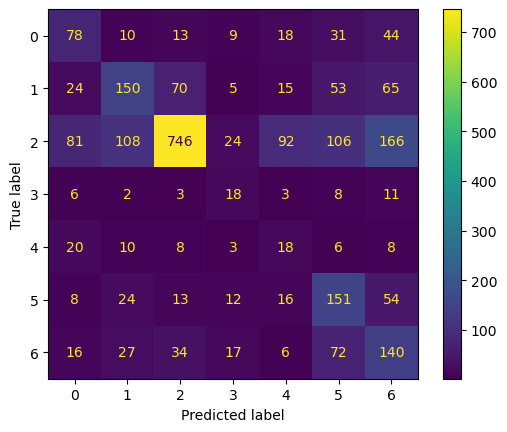

In [ ]:
load_best_model_and_evaluate(path_model_tuned, test_ds)

### Commento
Migliori risultati si sono ottenuti con la versione della rete NON-FINETUNING, si è arrivati al 67% di accuracy e con un apprendimento non proprio corretto però dalla confuzion matrix si può vedere una buona distinzione delle classe senza tendeze o preferenze verso una che l'altra classe. Con il finetuning non si sono raggiunti risultati migliori, forse perchè si sono sblaccati troppi layer per l'apprendimento. Da qui in poi conviene provare altre 3 reti: VGG19, ResNEt, InceptionV3(forse) e MobileNet(forse). Per quanto riguardo l'incremento delle dimensioni delle immagini, è vero che ci sono stati dei miglioramenti a livello di accuracy ma sono dei miglioramenti non molto significanti, per tale motivo si cercherà di mantenere la struttura batch_size 64 e dimensioni 250*250. 

### RESNET50

#### Experiment 1: Features Extraction  (52.72 dopo 4 epoche)

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
        weights='imagenet',  # load the network pretrained on ImageNet1K
        include_top=False)
        
base_model.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
LR = 0.0001
compile_model(model, 'adam', LR)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
path_model = './multiclass_models_sc/pretrained_RESNET_no_tuning_512_dp_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.6184 - accuracy: 0.3890
Epoch 00001: val_loss improved from inf to 1.42595, saving model to ./multiclass_models_sc\pretrained_RESNET_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 82s 179ms/step - loss: 1.6184 - accuracy: 0.3890 - val_loss: 1.4260 - val_accuracy: 0.4710


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.3663 - accuracy: 0.4892
Epoch 00002: val_loss improved from 1.42595 to 1.37891, saving model to ./multiclass_models_sc\pretrained_RESNET_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 78s 175ms/step - loss: 1.3663 - accuracy: 0.4892 - val_loss: 1.3789 - val_accuracy: 0.4874
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.2462 - accuracy: 0.5386
Epoch 00003: val_loss improved from 1.37891 to 1.25774, saving model to ./multiclass_models_sc\pretrained_RESNET_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 78s 175ms/step - loss: 1.2462 - accuracy: 0.5386 - val_loss: 1.2577 - val_accuracy: 0.5374
Epoch 4/40
438/438 [==============================] - ETA: 0s - loss: 1.1471 - accuracy: 0.5840
Epoch 00004: val_loss did not improve from 1.25774
438/438 [==============================] - 87s 196ms/step - loss: 1.1471 - accuracy: 0.58

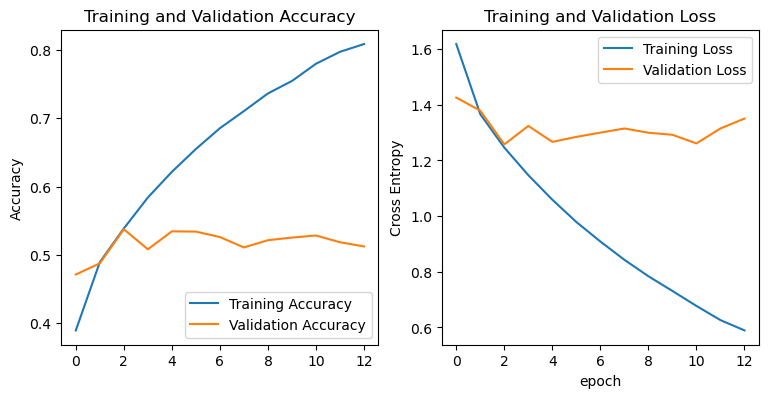

In [ ]:
show_history_fit(history)

41/41 [==============================] - 13s 222ms/step - loss: 1.2845 - accuracy: 0.5275
tf.Tensor([0 6 5 ... 6 5 0], shape=(2622,), dtype=int64)
tf.Tensor([0 5 2 ... 1 6 0], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3783    0.4286    0.4018       203
           1     0.4293    0.4450    0.4370       382
           2     0.8295    0.6070    0.7010      1323
           3     0.1864    0.2157    0.2000        51
           4     0.1224    0.2466    0.1636        73
           5     0.3863    0.5683    0.4600       278
           6     0.3317    0.4391    0.3779       312

    accuracy                         0.5278      2622
   macro avg     0.3806    0.4215    0.3916      2622
weighted avg     0.5979    0.5278    0.5507      2622



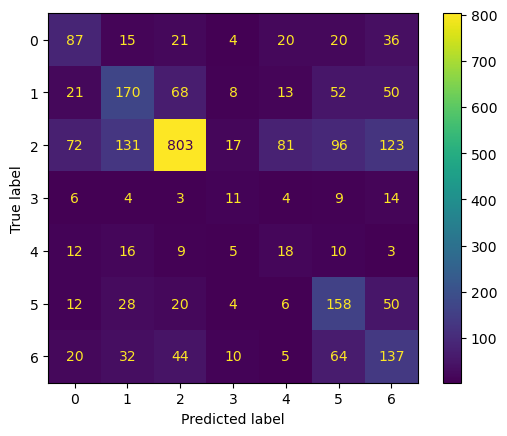

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
LR = 0.0001
compile_model(model, 'adam', LR)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
path_model = './multiclass_models_sc/pretrained_RESNET_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 2.4513 - accuracy: 0.3791
Epoch 00001: val_loss improved from inf to 2.12158, saving model to ./multiclass_models_sc\pretrained_RESNET_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


438/438 [==============================] - 79s 174ms/step - loss: 2.4513 - accuracy: 0.3791 - val_loss: 2.1216 - val_accuracy: 0.5053
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 2.1353 - accuracy: 0.4754
Epoch 00002: val_loss improved from 2.12158 to 2.00907, saving model to ./multiclass_models_sc\pretrained_RESNET_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5
438/438 [==============================] - 77s 172ms/step - loss: 2.1353 - accuracy: 0.4754 - val_loss: 2.0091 - val_accuracy: 0.5206
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.9678 - accuracy: 0.5273
Epoch 00003: val_loss improved from 2.00907 to 1.95743, saving model to ./multiclass_models_sc\pretrained_RESNET_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5
438/438 [==============================] - 77s 172ms/step - loss: 1.9678 - accuracy: 0.5273 - val_loss: 1.9574 - val_accuracy: 0.5187
Epoch 4/40
438/438 [==============================] - ETA: 0s - loss: 1.

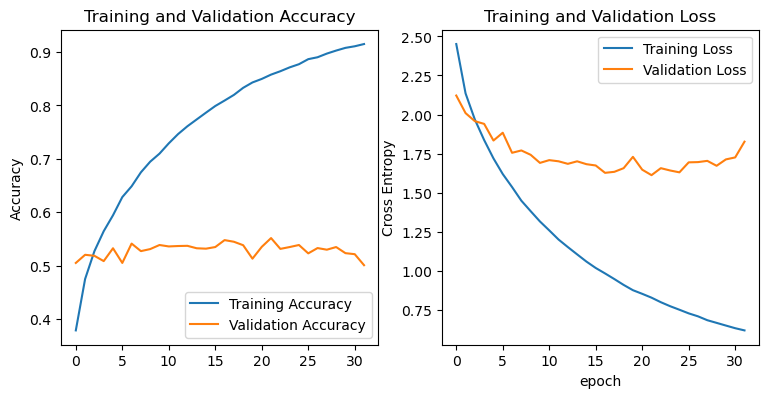

In [ ]:
show_history_fit(history)

41/41 [==============================] - 14s 224ms/step - loss: 1.6716 - accuracy: 0.5355
tf.Tensor([6 6 6 ... 6 2 1], shape=(2622,), dtype=int64)
tf.Tensor([1 2 6 ... 5 2 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3438    0.3793    0.3607       203
           1     0.4115    0.4319    0.4215       382
           2     0.8181    0.6357    0.7154      1323
           3     0.2500    0.1176    0.1600        51
           4     0.0952    0.1644    0.1206        73
           5     0.3872    0.5432    0.4521       278
           6     0.3543    0.4872    0.4103       312

    accuracy                         0.5355      2622
   macro avg     0.3800    0.3942    0.3772      2622
weighted avg     0.5901    0.5355    0.5535      2622



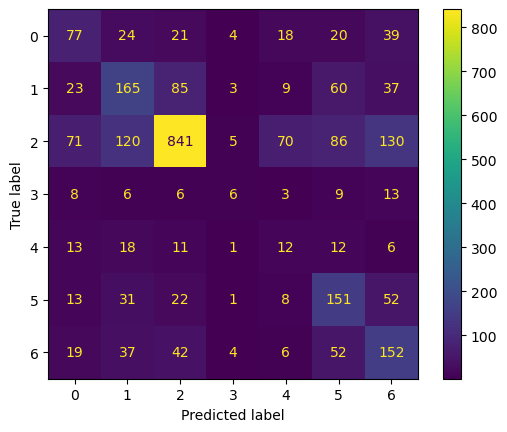

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

#### Experiment 2: Fine Tunining

##### Esperiemnto normale 51.49 dopo 0 epoche

In [ ]:
LR = 0.0001
path_model = './multiclass_models_sc/pretrained_RESNET_no_tuning_512_dp_epoch_40_adam_1e-4.h5'
model_finetune = tf.keras.models.load_model(path_model)
model_finetune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
model_finetune.trainable = True

base_model_resnet50 = model_finetune.get_layer("resnet50") # change the name looking at the summary IMPORTANT!
print("Number of layers in the base model: ", len(base_model_resnet50.layers))
base_model_resnet50.summary()

Number of layers in the base model:  175
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                  

In [ ]:
num_layer_trainable = 50

start_layer_to_train = len(base_model_resnet50.layers) - num_layer_trainable #

for layer in base_model_resnet50.layers[:start_layer_to_train]:
    #if layer.name.endswith('bn'):
    layer.trainable = False
    #else:
    #    layer.trainable = True

for layer in base_model_resnet50.layers[start_layer_to_train:]:
    if layer.name.endswith('bn'):
        layer.trainable = False


model_finetune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
compile_model(model_finetune, 'adam', LR)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
path_model_tuned = './multiclass_models_sc/pretrained_RESNET_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5'
history_tune, model_fitted_tuned = fit_model(model_finetune, train_ds, val_ds, path_model_tuned,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.2988 - accuracy: 0.5164
Epoch 00001: val_loss improved from inf to 1.39337, saving model to ./multiclass_models_sc\pretrained_RESNET_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


438/438 [==============================] - 114s 239ms/step - loss: 1.2988 - accuracy: 0.5164 - val_loss: 1.3934 - val_accuracy: 0.4905
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 0.9537 - accuracy: 0.6525
Epoch 00002: val_loss improved from 1.39337 to 1.38854, saving model to ./multiclass_models_sc\pretrained_RESNET_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 102s 231ms/step - loss: 0.9537 - accuracy: 0.6525 - val_loss: 1.3885 - val_accuracy: 0.5053
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.7629
Epoch 00003: val_loss did not improve from 1.38854
438/438 [==============================] - 102s 230ms/step - loss: 0.6590 - accuracy: 0.7629 - val_loss: 1.6675 - val_accuracy: 0.4889
Epoch 4/40
438/438 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8473
Epoch 00004: val_loss did not improve from 1.38854
438/438 [==============================] - 102s 231

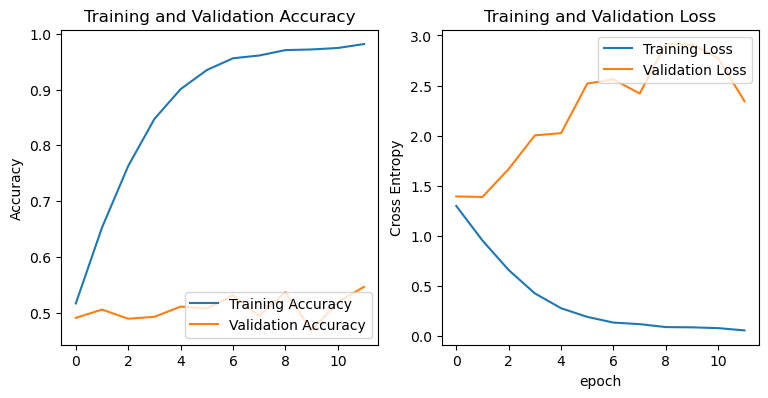

In [ ]:
show_history_fit(history_tune)

41/41 [==============================] - 8s 150ms/step - loss: 1.4319 - accuracy: 0.5149
tf.Tensor([2 6 2 ... 5 6 1], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3281    0.5123    0.4000       203
           1     0.5101    0.3953    0.4454       382
           2     0.8695    0.5790    0.6951      1323
           3     0.1589    0.3333    0.2152        51
           4     0.0884    0.2192    0.1260        73
           5     0.3573    0.6259    0.4549       278
           6     0.3456    0.3910    0.3669       312

    accuracy                         0.5149      2622
   macro avg     0.3797    0.4366    0.3862      2622
weighted avg     0.6230    0.5149    0.5462      2622



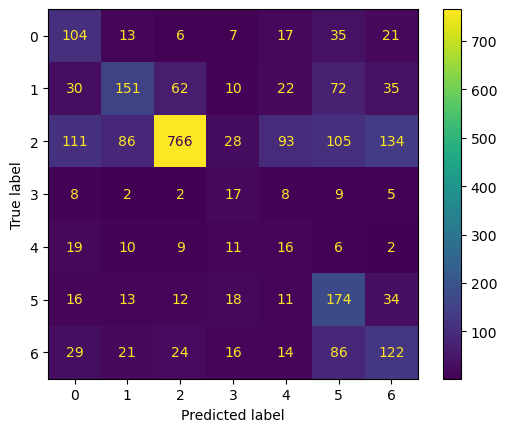

In [ ]:
load_best_model_and_evaluate(path_model_tuned, test_ds)

### MobilNet (Ripreso)

#### Experiment 1: Features extraction (51.64 e dopo 5 epoche)

In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
        weights='imagenet',  # load the network pretrained on ImageNet1K
        include_top=False)
        
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 125, 125, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 125, 125, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
#x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
LR = 0.0001
compile_model(model, 'adam', LR)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
path_model = './multiclass_models_sc/pretrained_MOBILENETV2_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,5)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.6653 - accuracy: 0.3613
Epoch 00001: val_loss improved from inf to 1.41741, saving model to ./multiclass_models_sc\pretrained_MOBILENETV2_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5
438/438 [==============================] - 58s 126ms/step - loss: 1.6653 - accuracy: 0.3613 - val_loss: 1.4174 - val_accuracy: 0.4790
Epoch 2/40


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


437/438 [============================>.] - ETA: 0s - loss: 1.4602 - accuracy: 0.4487
Epoch 00002: val_loss improved from 1.41741 to 1.38063, saving model to ./multiclass_models_sc\pretrained_MOBILENETV2_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5
438/438 [==============================] - 56s 125ms/step - loss: 1.4601 - accuracy: 0.4488 - val_loss: 1.3806 - val_accuracy: 0.4950
Epoch 3/40
437/438 [============================>.] - ETA: 0s - loss: 1.3653 - accuracy: 0.4918
Epoch 00003: val_loss improved from 1.38063 to 1.36895, saving model to ./multiclass_models_sc\pretrained_MOBILENETV2_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5
438/438 [==============================] - 57s 127ms/step - loss: 1.3654 - accuracy: 0.4919 - val_loss: 1.3689 - val_accuracy: 0.5000
Epoch 4/40
437/438 [============================>.] - ETA: 0s - loss: 1.2964 - accuracy: 0.5209
Epoch 00004: val_loss improved from 1.36895 to 1.34837, saving model to ./multiclass_models_sc\pretrained_MOBIL

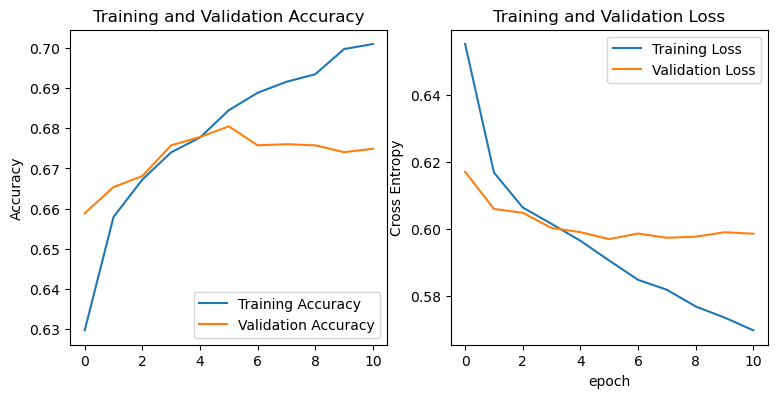

In [ ]:
show_history_fit(history)

41/41 [==============================] - 7s 116ms/step - loss: 1.3283 - accuracy: 0.5164
tf.Tensor([6 1 1 ... 2 5 2], shape=(2622,), dtype=int64)
tf.Tensor([1 1 1 ... 2 5 5], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3117    0.4729    0.3757       203
           1     0.4246    0.4424    0.4333       382
           2     0.8185    0.5896    0.6854      1323
           3     0.2000    0.2941    0.2381        51
           4     0.0720    0.1233    0.0909        73
           5     0.4377    0.5180    0.4745       278
           6     0.3249    0.4519    0.3780       312

    accuracy                         0.5164      2622
   macro avg     0.3699    0.4132    0.3823      2622
weighted avg     0.5899    0.5164    0.5405      2622



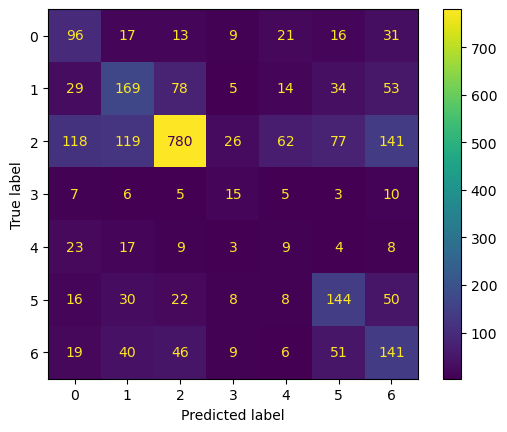

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

#### Experiment 2: fine tuning (55.42 dopo 0 epoche)

In [ ]:
LR = 0.0001
path_model = './multiclass_models_sc/pretrained_MOBILENETV2_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5'
model_finetune = tf.keras.models.load_model(path_model)
model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
model_finetune.trainable = True

base_model_resnet50 = model_finetune.get_layer("mobilenetv2_1.00_224") # change the name looking at the summary IMPORTANT!
print("Number of layers in the base model: ", len(base_model_resnet50.layers))
base_model_resnet50.summary()

Number of layers in the base model:  154
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 125, 125, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 125, 125, 32  128         ['Conv1[0][0]']                  
                                )     

In [ ]:
num_layer_trainable = 134

#start_layer_to_train = len(base_model_resnet50.layers) - num_layer_trainable

for layer in base_model_resnet50.layers[:num_layer_trainable]:
    #if layer.name.endswith('bn'):
    layer.trainable = False
    #else:
    #    layer.trainable = True

for layer in base_model_resnet50.layers[num_layer_trainable:]:
    if layer.name.endswith('BN'):
        layer.trainable = False
    else:
        layer.trainable = True


model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
compile_model(model_finetune, 'adam', LR)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
path_model_tuned = './multiclass_models_sc/pretrained_MOBILNETV2_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5'
history_tune, model_fitted_tuned = fit_model(model_finetune, train_ds, val_ds, path_model_tuned,40,5)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.0844 - accuracy: 0.6053
Epoch 00001: val_loss improved from inf to 1.20896, saving model to ./multiclass_models_sc\pretrained_MOBILNETV2_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 60s 130ms/step - loss: 1.0844 - accuracy: 0.6053 - val_loss: 1.2090 - val_accuracy: 0.5606
Epoch 2/40


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


437/438 [============================>.] - ETA: 0s - loss: 0.8184 - accuracy: 0.7157
Epoch 00002: val_loss did not improve from 1.20896
438/438 [==============================] - 58s 130ms/step - loss: 0.8183 - accuracy: 0.7158 - val_loss: 1.2146 - val_accuracy: 0.5637
Epoch 3/40
437/438 [============================>.] - ETA: 0s - loss: 0.6235 - accuracy: 0.7941
Epoch 00003: val_loss did not improve from 1.20896
438/438 [==============================] - 58s 130ms/step - loss: 0.6237 - accuracy: 0.7941 - val_loss: 1.2709 - val_accuracy: 0.5557
Epoch 4/40
437/438 [============================>.] - ETA: 0s - loss: 0.4655 - accuracy: 0.8527
Epoch 00004: val_loss did not improve from 1.20896
438/438 [==============================] - 58s 130ms/step - loss: 0.4655 - accuracy: 0.8528 - val_loss: 1.3888 - val_accuracy: 0.5450
Epoch 5/40
437/438 [============================>.] - ETA: 0s - loss: 0.3295 - accuracy: 0.9021
Epoch 00005: val_loss did not improve from 1.20896
438/438 [============

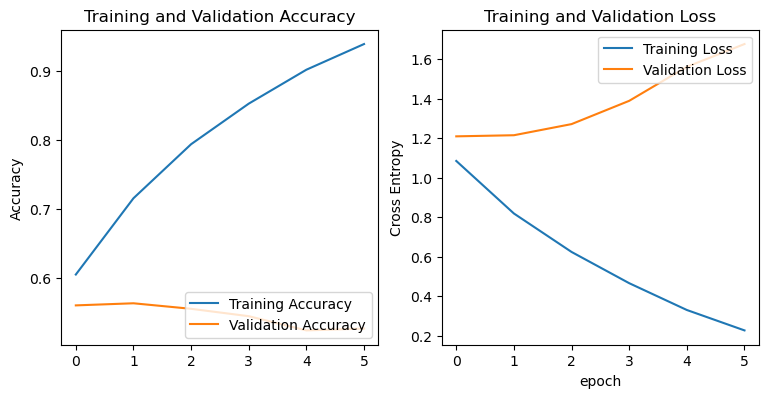

In [ ]:
show_history_fit(history_tune)

41/41 [==============================] - 7s 116ms/step - loss: 1.2306 - accuracy: 0.5534
tf.Tensor([0 6 6 ... 6 4 0], shape=(2622,), dtype=int64)
tf.Tensor([0 5 2 ... 1 6 0], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.4183    0.4286    0.4234       203
           1     0.5291    0.2853    0.3707       382
           2     0.7696    0.7196    0.7438      1323
           3     0.2273    0.0980    0.1370        51
           4     0.1053    0.1370    0.1190        73
           5     0.4667    0.4029    0.4324       278
           6     0.2899    0.5705    0.3844       312

    accuracy                         0.5542      2622
   macro avg     0.4009    0.3774    0.3730      2622
weighted avg     0.5891    0.5542    0.5596      2622



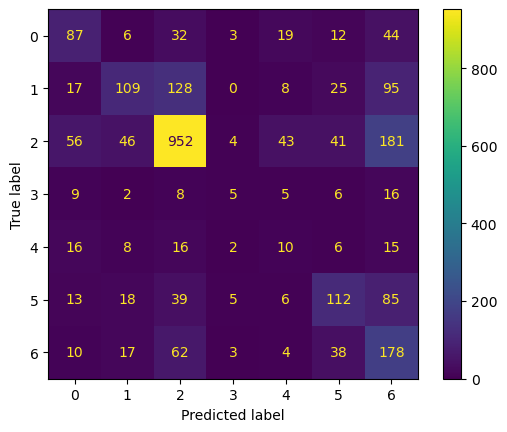

In [ ]:
load_best_model_and_evaluate(path_model_tuned, test_ds)

### XCEPTION

#### Experiment 1 (50.19 dopo 5 epoche)

In [ ]:
base_model = tf.keras.applications.xception.Xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
        weights='imagenet',  # load the network pretrained on ImageNet1K
        include_top=False)

base_model.trainable = False

print('Number of layers Xception: ', len(base_model.layers))
base_model.summary()

Number of layers Xception:  132
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                          

In [ ]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
LR = 0.0001
compile_model(model, 'adam', LR)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
path_model = './multiclass_models_sc/pretrained_XCEPTION_no_tuning_512_dp_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.6091 - accuracy: 0.3882
Epoch 00001: val_loss improved from inf to 1.47044, saving model to ./multiclass_models_sc\pretrained_XCEPTION_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 105s 231ms/step - loss: 1.6091 - accuracy: 0.3882 - val_loss: 1.4704 - val_accuracy: 0.4748


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.4650 - accuracy: 0.4469
Epoch 00002: val_loss improved from 1.47044 to 1.45556, saving model to ./multiclass_models_sc\pretrained_XCEPTION_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 98s 222ms/step - loss: 1.4650 - accuracy: 0.4469 - val_loss: 1.4556 - val_accuracy: 0.4653
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.4100 - accuracy: 0.4696
Epoch 00003: val_loss did not improve from 1.45556
438/438 [==============================] - 98s 221ms/step - loss: 1.4100 - accuracy: 0.4696 - val_loss: 1.4906 - val_accuracy: 0.4664
Epoch 4/40
438/438 [==============================] - ETA: 0s - loss: 1.3724 - accuracy: 0.4860
Epoch 00004: val_loss did not improve from 1.45556
438/438 [==============================] - 98s 221ms/step - loss: 1.3724 - accuracy: 0.4860 - val_loss: 1.4712 - val_accuracy: 0.4733
Epoch 5/40
438/438 [==============================] - 

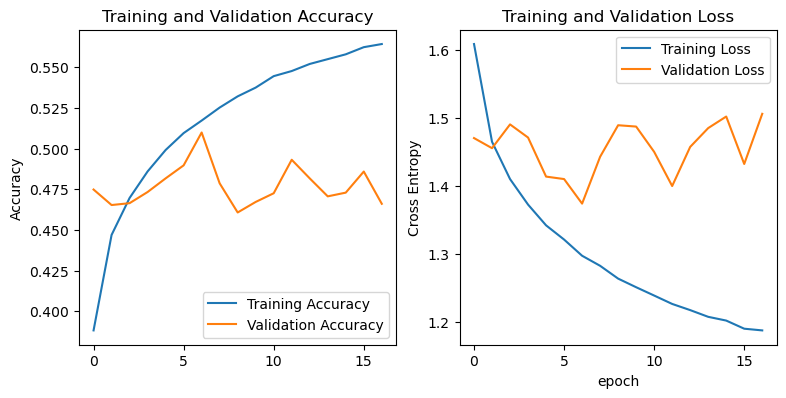

In [ ]:
show_history_fit(history)

41/41 [==============================] - 10s 197ms/step - loss: 1.3717 - accuracy: 0.5015
tf.Tensor([6 2 6 ... 0 6 2], shape=(2622,), dtype=int64)
tf.Tensor([1 2 6 ... 5 2 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3033    0.4975    0.3769       203
           1     0.4246    0.3979    0.4108       382
           2     0.8203    0.5865    0.6840      1323
           3     0.1203    0.3137    0.1739        51
           4     0.1161    0.1781    0.1405        73
           5     0.3500    0.4281    0.3851       278
           6     0.3475    0.4455    0.3904       312

    accuracy                         0.5019      2622
   macro avg     0.3546    0.4068    0.3660      2622
weighted avg     0.5833    0.5019    0.5287      2622



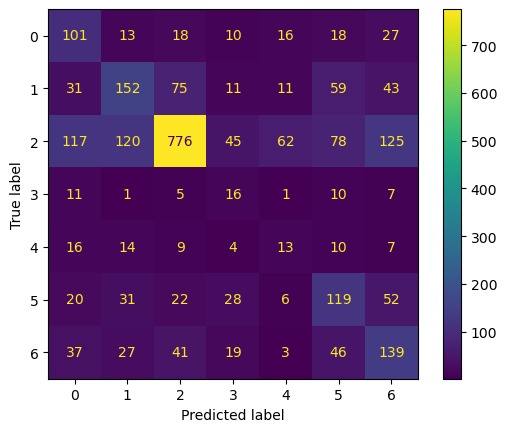

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

#### Experiment 2 (50.38 dopo 0 epoche)

In [ ]:
LR = 0.0001
path_model = './multiclass_models_sc/pretrained_XCEPTION_no_tuning_512_dp_epoch_40_adam_1e-4.h5'
model_finetune = tf.keras.models.load_model(path_model)
model_finetune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
model_finetune.trainable = True

base_model_xception = model_finetune.get_layer("xception") # change the name looking at the summary IMPORTANT!
print("Number of layers in the base model: ", len(base_model_xception.layers))
base_model_xception.summary()

Number of layers in the base model:  132
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                 

In [ ]:
num_layer_trainable = 102

#start_layer_to_train = len(base_model_resnet50.layers) - num_layer_trainable

for layer in base_model_xception.layers[:num_layer_trainable]:
    #if layer.name.endswith('bn'):
    layer.trainable = False
    #else:
    #    layer.trainable = True

for layer in base_model_xception.layers[num_layer_trainable:]:
    if layer.name.endswith('bn'):
        layer.trainable = False
    else:
        layer.trainable = True


model_finetune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
compile_model(model_finetune, 'adam', LR)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
path_model_tuned = './multiclass_models_sc/pretrained_XCEPTION_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5'
history_tune, model_fitted_tuned = fit_model(model_finetune, train_ds, val_ds, path_model_tuned,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.2233 - accuracy: 0.5483
Epoch 00001: val_loss improved from inf to 1.35613, saving model to ./multiclass_models_sc\pretrained_XCEPTION_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


438/438 [==============================] - 132s 295ms/step - loss: 1.2233 - accuracy: 0.5483 - val_loss: 1.3561 - val_accuracy: 0.5053
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.7511
Epoch 00002: val_loss did not improve from 1.35613
438/438 [==============================] - 129s 293ms/step - loss: 0.6898 - accuracy: 0.7511 - val_loss: 1.4540 - val_accuracy: 0.5195
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8939
Epoch 00003: val_loss did not improve from 1.35613
438/438 [==============================] - 130s 293ms/step - loss: 0.3130 - accuracy: 0.8939 - val_loss: 2.0769 - val_accuracy: 0.4683
Epoch 4/40
438/438 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9627
Epoch 00004: val_loss did not improve from 1.35613
438/438 [==============================] - 130s 293ms/step - loss: 0.1261 - accuracy: 0.9627 - val_loss: 2.3152 - val_accuracy: 0.5149
Epoch 5/40
438/438 

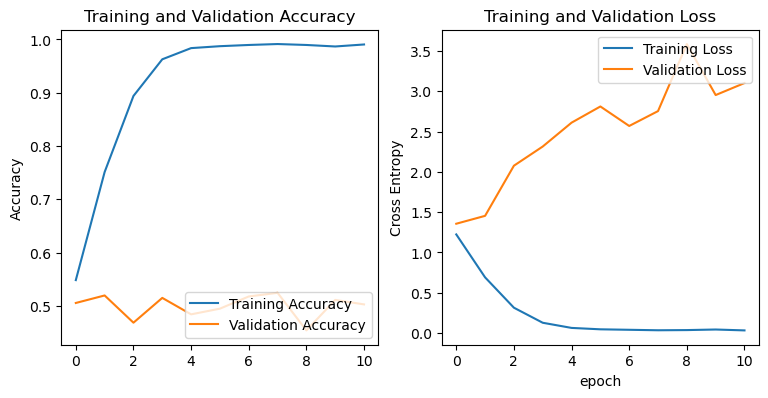

In [ ]:
show_history_fit(history_tune)

41/41 [==============================] - 10s 197ms/step - loss: 1.3767 - accuracy: 0.5038
tf.Tensor([1 3 0 ... 1 2 6], shape=(2622,), dtype=int64)
tf.Tensor([2 3 5 ... 1 2 6], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3673    0.4089    0.3869       203
           1     0.4066    0.4215    0.4139       382
           2     0.8578    0.5699    0.6848      1323
           3     0.1282    0.1961    0.1550        51
           4     0.1180    0.2603    0.1624        73
           5     0.3878    0.5036    0.4382       278
           6     0.2956    0.4936    0.3697       312

    accuracy                         0.5038      2622
   macro avg     0.3659    0.4077    0.3730      2622
weighted avg     0.6026    0.5038    0.5338      2622



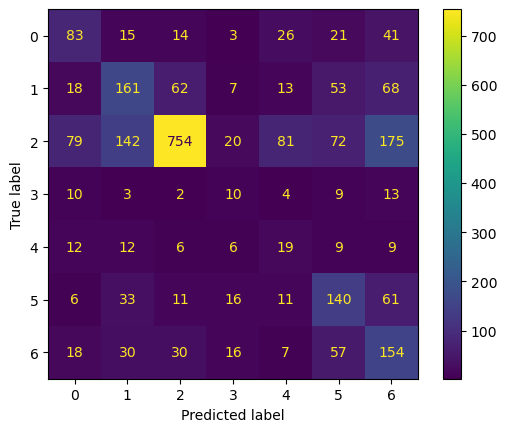

In [ ]:
load_best_model_and_evaluate(path_model_tuned, test_ds)

### InceptionV3

#### Experiment 1: (50.92 andamento oscillatorio)

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
        weights='imagenet',  # load the network pretrained on ImageNet1K
        include_top=False)

base_model.trainable = False

print('Number of layers Xception: ', len(base_model.layers))
base_model.summary()

Number of layers Xception:  311
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 124, 124, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 124, 124, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                      

In [ ]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
LR = 0.0001
compile_model(model, 'adam', LR)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
path_model = './multiclass_models_sc/pretrained_INCEPTIONV3_no_tuning_512_dp_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.8637 - accuracy: 0.3406
Epoch 00001: val_loss improved from inf to 1.74130, saving model to ./multiclass_models_sc\pretrained_INCEPTIONV3_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 67s 143ms/step - loss: 1.8637 - accuracy: 0.3406 - val_loss: 1.7413 - val_accuracy: 0.3924
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.6495 - accuracy: 0.4031
Epoch 00002: val_loss improved from 1.74130 to 1.40871, saving model to ./multiclass_models_sc\pretrained_INCEPTIONV3_no_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 60s 134ms/step - loss: 1.6495 - accuracy: 0.4031 - val_loss: 1.4087 - val_accuracy: 0.4832
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.5591 - accuracy: 0.4296
Epoch 00003: val_loss improved from 1.40871 to 1.33660, saving model to ./multiclass_models_sc\pretrained_INCEPTIONV3_no_tuning_512_dp

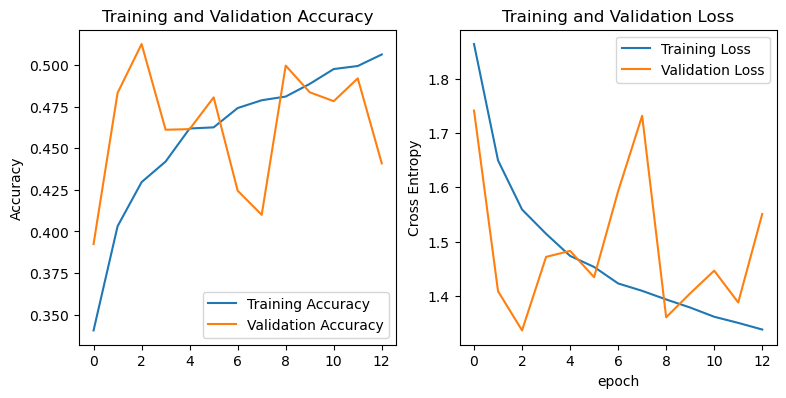

In [ ]:
show_history_fit(history)

41/41 [==============================] - 8s 134ms/step - loss: 1.3369 - accuracy: 0.5088
tf.Tensor([1 2 1 ... 4 6 5], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 3 6 6], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3810    0.2759    0.3200       203
           1     0.3813    0.4581    0.4162       382
           2     0.7778    0.6349    0.6991      1323
           3     0.1389    0.2941    0.1887        51
           4     0.1000    0.3699    0.1574        73
           5     0.4824    0.3453    0.4025       278
           6     0.3510    0.4038    0.3756       312

    accuracy                         0.5092      2622
   macro avg     0.3732    0.3974    0.3656      2622
weighted avg     0.5759    0.5092    0.5336      2622



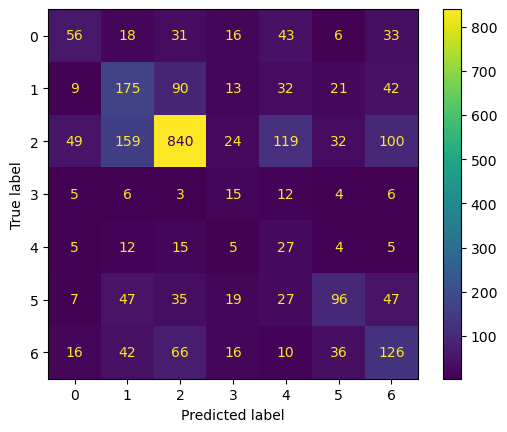

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

#### Experiment 2: 51.75 dopo 15 epoche, oscillatorio

In [ ]:
LR = 0.0001
path_model = './multiclass_models_sc/pretrained_INCEPTIONV3_no_tuning_512_dp_epoch_40_adam_1e-4.h5'
model_finetune = tf.keras.models.load_model(path_model)
model_finetune.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
model_finetune.trainable = True

base_model_inception_v3 = model_finetune.get_layer("inception_v3") # change the name looking at the summary IMPORTANT!
print("Number of layers in the base model: ", len(base_model_inception_v3.layers))
base_model_inception_v3.summary()

Number of layers in the base model:  311
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 124, 124, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 124, 124, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )             

In [ ]:
num_layer_trainable = 300

#start_layer_to_train = len(base_model_resnet50.layers) - num_layer_trainable

for layer in base_model_inception_v3.layers[:num_layer_trainable]:
    #if layer.name.endswith('bn'):
    layer.trainable = False
    #else:
    #    layer.trainable = True

for layer in base_model_inception_v3.layers[num_layer_trainable:]:
    if layer.name.endswith('BN'):
        layer.trainable = False
    else:
        layer.trainable = True


model_finetune.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
compile_model(model_finetune, 'adam', LR)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
path_model_tuned = './multiclass_models_sc/pretrained_INCEPTIONV3_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5'
history_tune, model_fitted_tuned = fit_model(model_finetune, train_ds, val_ds, path_model_tuned,40,10)

Epoch 1/40
438/438 [==============================] - ETA: 0s - loss: 1.5225 - accuracy: 0.4347
Epoch 00001: val_loss improved from inf to 1.45925, saving model to ./multiclass_models_sc\pretrained_INCEPTIONV3_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 65s 140ms/step - loss: 1.5225 - accuracy: 0.4347 - val_loss: 1.4592 - val_accuracy: 0.4710
Epoch 2/40
438/438 [==============================] - ETA: 0s - loss: 1.4846 - accuracy: 0.4513
Epoch 00002: val_loss improved from 1.45925 to 1.39346, saving model to ./multiclass_models_sc\pretrained_INCEPTIONV3_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5
438/438 [==============================] - 62s 140ms/step - loss: 1.4846 - accuracy: 0.4513 - val_loss: 1.3935 - val_accuracy: 0.5019
Epoch 3/40
438/438 [==============================] - ETA: 0s - loss: 1.4594 - accuracy: 0.4630
Epoch 00003: val_loss did not improve from 1.39346
438/438 [==============================] - 62s 139ms/step - loss: 1.4594 - accu

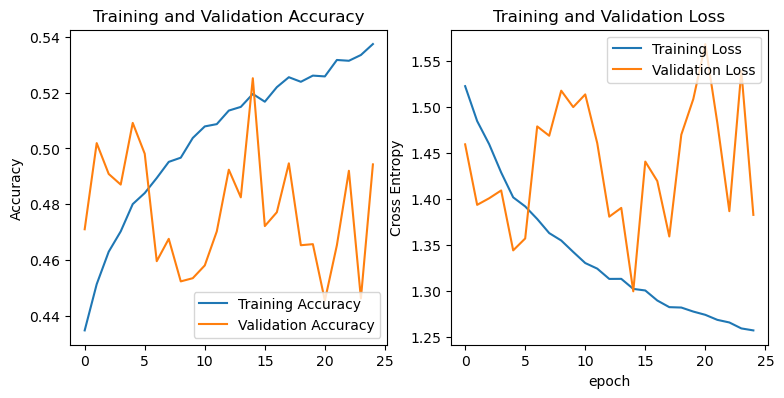

In [ ]:
show_history_fit(history_tune)

41/41 [==============================] - 8s 138ms/step - loss: 1.3080 - accuracy: 0.5179
tf.Tensor([6 4 6 ... 3 2 5], shape=(2622,), dtype=int64)
tf.Tensor([1 5 2 ... 2 2 5], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3004    0.3596    0.3274       203
           1     0.4055    0.3482    0.3746       382
           2     0.7559    0.6788    0.7153      1323
           3     0.1379    0.1569    0.1468        51
           4     0.1137    0.3973    0.1768        73
           5     0.3951    0.4604    0.4252       278
           6     0.3894    0.2821    0.3271       312

    accuracy                         0.5175      2622
   macro avg     0.3568    0.3833    0.3562      2622
weighted avg     0.5578    0.5175    0.5326      2622



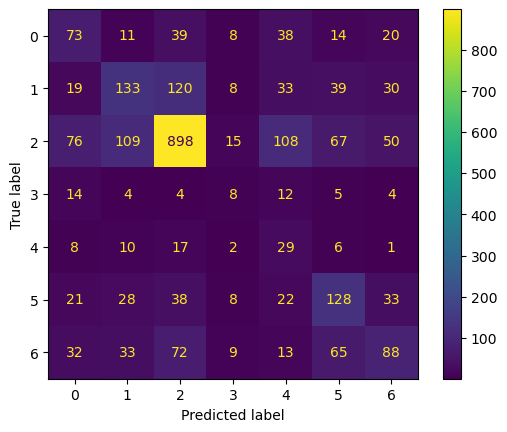

In [ ]:
load_best_model_and_evaluate(path_model_tuned, test_ds)

## Prove con data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.1), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.2), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
  layers.RandomContrast(0.5)
  ]
)

### 1

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)


x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 250, 250, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                             

In [ ]:
path_model = './extra_multiclass_models_sc/ex1_scratch_DATA_AUG_DROP0.4_32_2x256_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=150, patience_par=110)

Epoch 1/150
438/438 [==============================] - ETA: 0s - loss: 1.9075 - accuracy: 0.1983
Epoch 00001: val_loss improved from inf to 1.94200, saving model to ./extra_multiclass_models_sc\ex1_scratch_DATA_AUG_DROP0.4_32_2x256_epoch_40_adam_1e-4.h5
438/438 [==============================] - 67s 127ms/step - loss: 1.9075 - accuracy: 0.1983 - val_loss: 1.9420 - val_accuracy: 0.1873
Epoch 2/150
438/438 [==============================] - ETA: 0s - loss: 1.8541 - accuracy: 0.2451
Epoch 00002: val_loss improved from 1.94200 to 1.77200, saving model to ./extra_multiclass_models_sc\ex1_scratch_DATA_AUG_DROP0.4_32_2x256_epoch_40_adam_1e-4.h5
438/438 [==============================] - 55s 124ms/step - loss: 1.8541 - accuracy: 0.2451 - val_loss: 1.7720 - val_accuracy: 0.3169
Epoch 3/150
438/438 [==============================] - ETA: 0s - loss: 1.8306 - accuracy: 0.2594
Epoch 00003: val_loss did not improve from 1.77200
438/438 [==============================] - 55s 123ms/step - loss: 1.8306

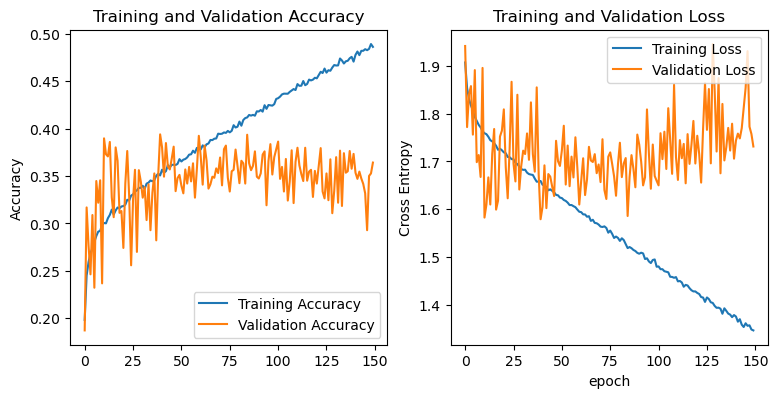

In [ ]:
show_history_fit(history)

41/41 [==============================] - 10s 200ms/step - loss: 1.5898 - accuracy: 0.3860
tf.Tensor([2 5 2 ... 5 5 5], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2705    0.2759    0.2732       203
           1     0.2612    0.3063    0.2819       382
           2     0.7353    0.4641    0.5690      1323
           3     0.0769    0.1373    0.0986        51
           4     0.1102    0.3699    0.1698        73
           5     0.2301    0.5719    0.3282       278
           6     0.3048    0.1026    0.1535       312

    accuracy                         0.3860      2622
   macro avg     0.2841    0.3183    0.2677      2622
weighted avg     0.4952    0.3860    0.4091      2622



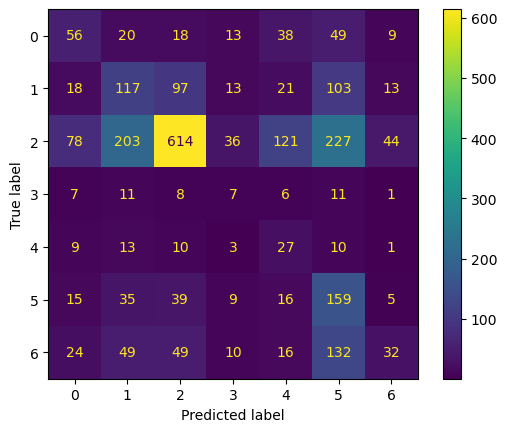

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### 2

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
#x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)


x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 124, 124, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 122, 122, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 61, 128)      0         
 2D)                                                       

In [ ]:
path_model = './extra_multiclass_models_sc/2_scratch_DROP0.4_64_2x256_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=100, patience_par=50)

Epoch 1/100
438/438 [==============================] - ETA: 0s - loss: 1.9048 - accuracy: 0.1978
Epoch 00001: val_loss improved from inf to 1.84685, saving model to ./extra_multiclass_models_sc\2_scratch_DROP0.4_64_2x256_epoch_40_adam_1e-4.h5
438/438 [==============================] - 144s 321ms/step - loss: 1.9048 - accuracy: 0.1978 - val_loss: 1.8469 - val_accuracy: 0.2441
Epoch 2/100
438/438 [==============================] - ETA: 0s - loss: 1.8497 - accuracy: 0.2483
Epoch 00002: val_loss improved from 1.84685 to 1.73397, saving model to ./extra_multiclass_models_sc\2_scratch_DROP0.4_64_2x256_epoch_40_adam_1e-4.h5
438/438 [==============================] - 137s 306ms/step - loss: 1.8497 - accuracy: 0.2483 - val_loss: 1.7340 - val_accuracy: 0.3738
Epoch 3/100
438/438 [==============================] - ETA: 0s - loss: 1.8279 - accuracy: 0.2627
Epoch 00003: val_loss improved from 1.73397 to 1.67111, saving model to ./extra_multiclass_models_sc\2_scratch_DROP0.4_64_2x256_epoch_40_adam_1

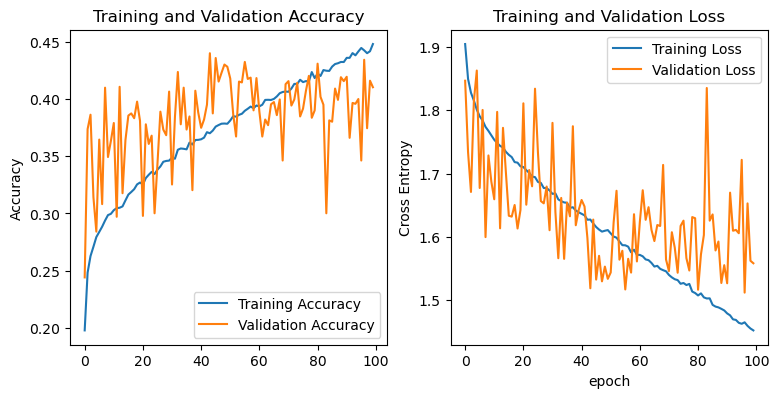

In [ ]:
show_history_fit(history)

41/41 [==============================] - 7s 127ms/step - loss: 1.5237 - accuracy: 0.4222
tf.Tensor([5 5 1 ... 2 5 2], shape=(2622,), dtype=int64)
tf.Tensor([1 1 1 ... 2 5 5], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2674    0.3596    0.3067       203
           1     0.3516    0.3534    0.3525       382
           2     0.7748    0.5019    0.6092      1323
           3     0.0977    0.2549    0.1413        51
           4     0.1296    0.2877    0.1787        73
           5     0.2599    0.4245    0.3224       278
           6     0.2340    0.2692    0.2504       312

    accuracy                         0.4226      2622
   macro avg     0.3021    0.3502    0.3087      2622
weighted avg     0.5238    0.4226    0.4542      2622



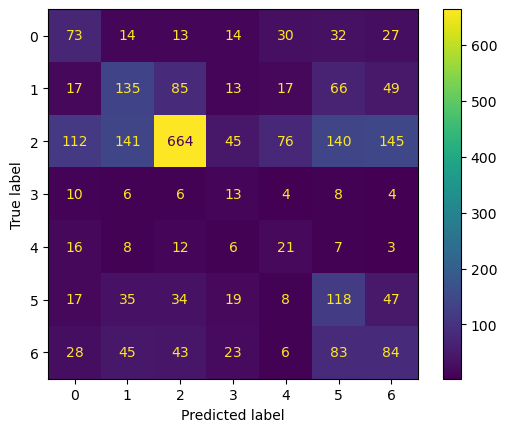

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### 3

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
#x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(64, (5, 5), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 196, 196, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                         

In [ ]:
path_model = './extra_multiclass_models_sc/3_scratch_DROP0.4_64_2x256_512_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=100, patience_par=50) #200x200

Epoch 1/100
438/438 [==============================] - ETA: 0s - loss: 1.9003 - accuracy: 0.2031
Epoch 00001: val_loss improved from inf to 1.86670, saving model to ./extra_multiclass_models_sc\3_scratch_DROP0.4_64_2x256_512_epoch_40_adam_1e-4.h5
438/438 [==============================] - 82s 171ms/step - loss: 1.9003 - accuracy: 0.2031 - val_loss: 1.8667 - val_accuracy: 0.2513
Epoch 2/100
438/438 [==============================] - ETA: 0s - loss: 1.8284 - accuracy: 0.2623
Epoch 00002: val_loss improved from 1.86670 to 1.86491, saving model to ./extra_multiclass_models_sc\3_scratch_DROP0.4_64_2x256_512_epoch_40_adam_1e-4.h5
438/438 [==============================] - 78s 175ms/step - loss: 1.8284 - accuracy: 0.2623 - val_loss: 1.8649 - val_accuracy: 0.2879
Epoch 3/100
438/438 [==============================] - ETA: 0s - loss: 1.7974 - accuracy: 0.2799
Epoch 00003: val_loss improved from 1.86491 to 1.81638, saving model to ./extra_multiclass_models_sc\3_scratch_DROP0.4_64_2x256_512_epoch

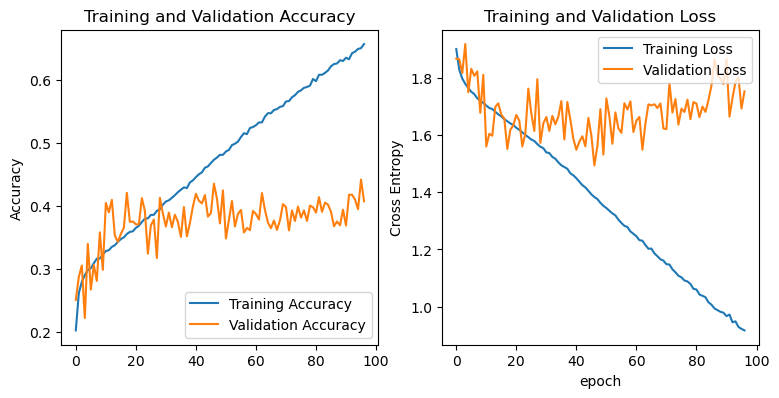

In [ ]:
show_history_fit(history)

41/41 [==============================] - 6s 116ms/step - loss: 1.5142 - accuracy: 0.4394
tf.Tensor([2 6 2 ... 5 6 6], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3348    0.3793    0.3557       203
           1     0.3820    0.2670    0.3143       382
           2     0.7750    0.5336    0.6321      1323
           3     0.0727    0.1569    0.0994        51
           4     0.1286    0.1233    0.1259        73
           5     0.2828    0.4964    0.3603       278
           6     0.2051    0.3590    0.2611       312

    accuracy                         0.4394      2622
   macro avg     0.3116    0.3308    0.3070      2622
weighted avg     0.5320    0.4394    0.4670      2622



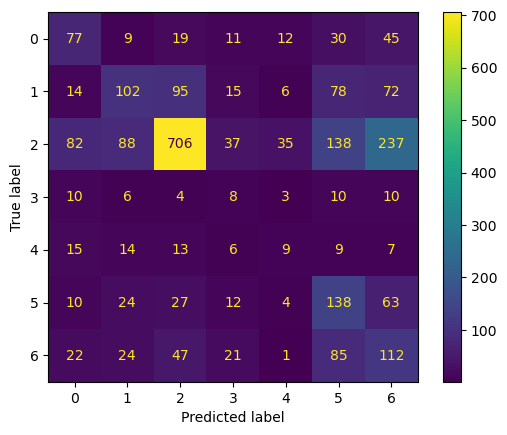

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### 4

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
#x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(64, (5, 5), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 196, 196, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                         

In [ ]:
path_model = './extra_multiclass_models_sc/4_scratch_DROP0.4_64_2x256_512_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, epochs_par=100, patience_par=50) #200x200

Epoch 1/100
438/438 [==============================] - ETA: 0s - loss: 1.9113 - accuracy: 0.1943
Epoch 00001: val_loss improved from inf to 1.85752, saving model to ./extra_multiclass_models_sc\4_scratch_DROP0.4_64_2x256_512_epoch_40_adam_1e-4.h5
438/438 [==============================] - 84s 174ms/step - loss: 1.9113 - accuracy: 0.1943 - val_loss: 1.8575 - val_accuracy: 0.3291
Epoch 2/100
438/438 [==============================] - ETA: 0s - loss: 1.8419 - accuracy: 0.2505
Epoch 00002: val_loss improved from 1.85752 to 1.85101, saving model to ./extra_multiclass_models_sc\4_scratch_DROP0.4_64_2x256_512_epoch_40_adam_1e-4.h5
438/438 [==============================] - 75s 168ms/step - loss: 1.8419 - accuracy: 0.2505 - val_loss: 1.8510 - val_accuracy: 0.2754
Epoch 3/100
438/438 [==============================] - ETA: 0s - loss: 1.8075 - accuracy: 0.2742
Epoch 00003: val_loss improved from 1.85101 to 1.79182, saving model to ./extra_multiclass_models_sc\4_scratch_DROP0.4_64_2x256_512_epoch

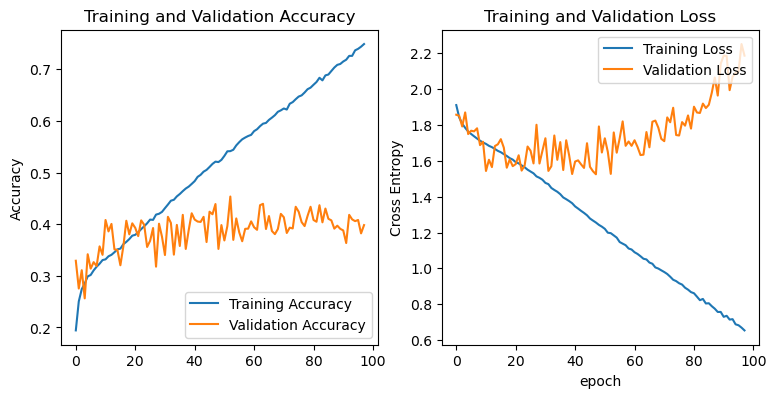

In [ ]:
show_history_fit(history)

41/41 [==============================] - 6s 114ms/step - loss: 1.5276 - accuracy: 0.4340
tf.Tensor([2 6 2 ... 5 6 6], shape=(2622,), dtype=int64)
tf.Tensor([2 2 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2334    0.3990    0.2945       203
           1     0.3718    0.2696    0.3126       382
           2     0.7736    0.5321    0.6305      1323
           3     0.0578    0.1961    0.0893        51
           4     0.1250    0.2329    0.1627        73
           5     0.3815    0.3705    0.3759       278
           6     0.2358    0.3846    0.2923       312

    accuracy                         0.4340      2622
   macro avg     0.3113    0.3407    0.3083      2622
weighted avg     0.5357    0.4340    0.4674      2622



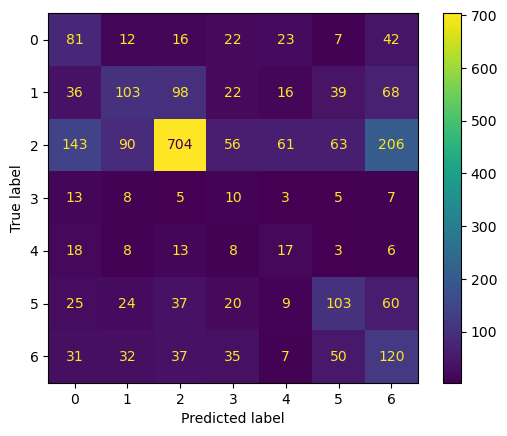

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### 5

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.001))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 95, 95, 128)       73856     
                                                           

In [ ]:
path_model = './extra_multiclass_models_sc/5_scratch_32_2x256_512_1024_dp_regularL1_batchnorm_epoch_100_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, 100, 50) #200x20

Epoch 1/100
438/438 [==============================] - ETA: 0s - loss: 35.9467 - accuracy: 0.2396
Epoch 00001: val_loss improved from inf to 16.88369, saving model to ./extra_multiclass_models_sc\5_scratch_32_2x256_512_1024_dp_regularL1_batchnorm_epoch_100_adam_1e-4.h5
438/438 [==============================] - 101s 219ms/step - loss: 35.9467 - accuracy: 0.2396 - val_loss: 16.8837 - val_accuracy: 0.1072
Epoch 2/100
438/438 [==============================] - ETA: 0s - loss: 10.0545 - accuracy: 0.2718
Epoch 00002: val_loss improved from 16.88369 to 6.46652, saving model to ./extra_multiclass_models_sc\5_scratch_32_2x256_512_1024_dp_regularL1_batchnorm_epoch_100_adam_1e-4.h5
438/438 [==============================] - 94s 212ms/step - loss: 10.0545 - accuracy: 0.2718 - val_loss: 6.4665 - val_accuracy: 0.2334
Epoch 3/100
438/438 [==============================] - ETA: 0s - loss: 4.6417 - accuracy: 0.2837
Epoch 00003: val_loss improved from 6.46652 to 3.64604, saving model to ./extra_multicl

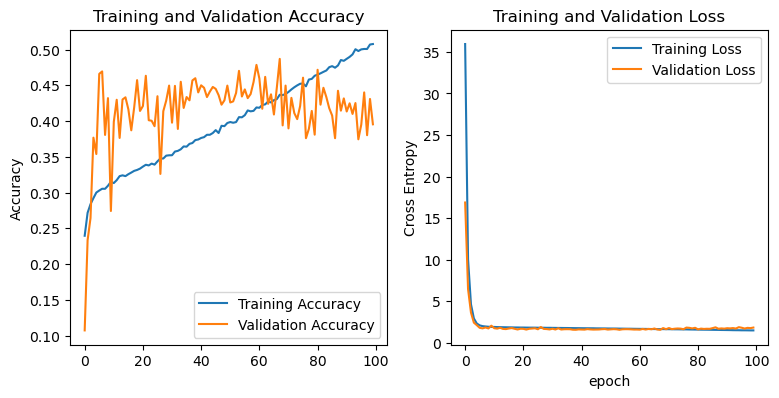

In [ ]:
show_history_fit(history)

41/41 [==============================] - 6s 97ms/step - loss: 1.5730 - accuracy: 0.5008
tf.Tensor([6 2 5 ... 5 1 0], shape=(2622,), dtype=int64)
tf.Tensor([0 5 2 ... 1 6 0], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.3407    0.1527    0.2109       203
           1     0.2718    0.2696    0.2707       382
           2     0.6775    0.7271    0.7014      1323
           3     0.1200    0.0588    0.0789        51
           4     0.2000    0.1233    0.1525        73
           5     0.3434    0.4496    0.3894       278
           6     0.2685    0.2564    0.2623       312

    accuracy                         0.5008      2622
   macro avg     0.3174    0.2911    0.2952      2622
weighted avg     0.4841    0.5008    0.4880      2622



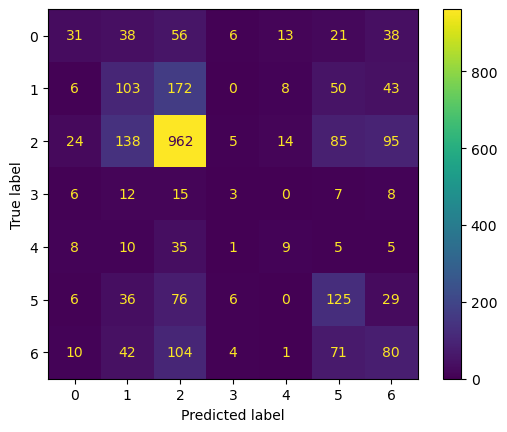

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### 6

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
#x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'sgd', 0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 96)        34944     
                                                                 
 batch_normalization_4 (Batc  (None, 60, 60, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 96)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 256)       6146

In [ ]:
path_model = './extra_multiclass_models_sc/6_bis_scratch_32_2x256_512_1000_dp_batchnorm_epoch_100_sgd_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, 100, 30) #250x250

Epoch 1/100
437/438 [============================>.] - ETA: 0s - loss: 1.9335 - accuracy: 0.1905
Epoch 00001: val_loss improved from inf to 1.76458, saving model to ./extra_multiclass_models_sc\6_bis_scratch_32_2x256_512_1000_dp_batchnorm_epoch_100_sgd_1e-4.h5
438/438 [==============================] - 53s 117ms/step - loss: 1.9334 - accuracy: 0.1906 - val_loss: 1.7646 - val_accuracy: 0.3806
Epoch 2/100
437/438 [============================>.] - ETA: 0s - loss: 1.8847 - accuracy: 0.2274
Epoch 00002: val_loss did not improve from 1.76458
438/438 [==============================] - 53s 119ms/step - loss: 1.8847 - accuracy: 0.2274 - val_loss: 1.8319 - val_accuracy: 0.3059
Epoch 3/100
437/438 [============================>.] - ETA: 0s - loss: 1.8576 - accuracy: 0.2470
Epoch 00003: val_loss improved from 1.76458 to 1.74475, saving model to ./extra_multiclass_models_sc\6_bis_scratch_32_2x256_512_1000_dp_batchnorm_epoch_100_sgd_1e-4.h5
438/438 [==============================] - 53s 119ms/step 

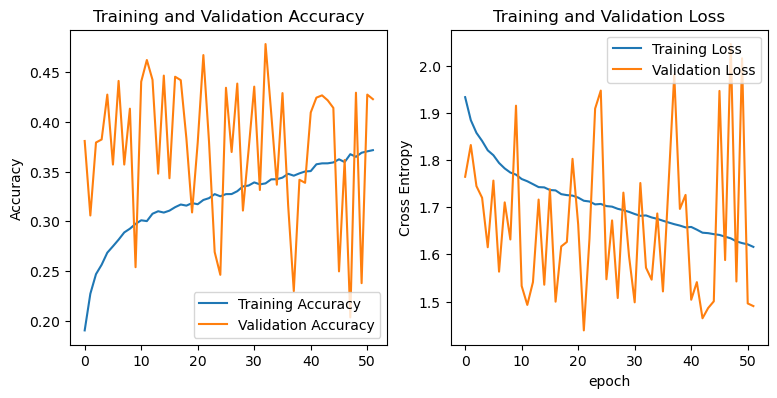

In [ ]:
show_history_fit(history)

41/41 [==============================] - 5s 92ms/step - loss: 1.4319 - accuracy: 0.4786
tf.Tensor([1 2 5 ... 5 1 2], shape=(2622,), dtype=int64)
tf.Tensor([0 5 2 ... 1 6 0], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.4074    0.0542    0.0957       203
           1     0.2459    0.2723    0.2584       382
           2     0.6297    0.7521    0.6855      1323
           3     0.0000    0.0000    0.0000        51
           4     0.1489    0.1918    0.1677        73
           5     0.2722    0.3633    0.3112       278
           6     0.2500    0.0962    0.1389       312

    accuracy                         0.4786      2622
   macro avg     0.2792    0.2471    0.2368      2622
weighted avg     0.4479    0.4786    0.4451      2622



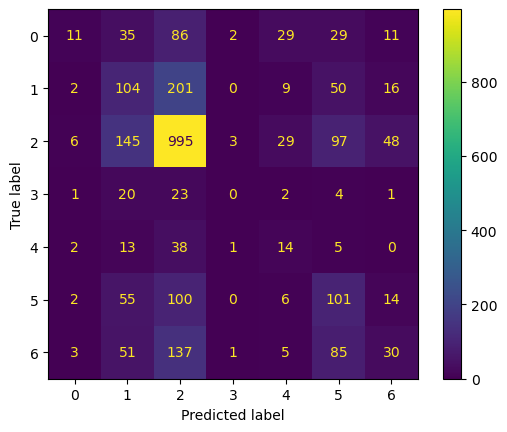

In [ ]:
path_model = './extra_multiclass_models_sc/6_bis_scratch_32_2x256_512_1000_dp_batchnorm_epoch_100_sgd_1e-4.h5'
load_best_model_and_evaluate(path_model, test_ds)

### 7

In [11]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
l1 = layers.Rescaling(1./255)(input)
l1 = layers.Conv2D(filters=128, kernel_size=(11,11), activation='relu')(l1) #, strides=(4,4)
l1 = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l1)
l1 = layers.MaxPool2D(pool_size=(3,3))(l1)

l1_out = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l1)
l1_out = layers.GlobalAveragePooling2D()(l1_out)
l1_out = layers.Dense(512, activation='relu')(l1_out)
l1_out = layers.Dropout(0.4)(l1_out)
l1_out = layers.Dense(256, activation='relu')(l1_out)

l2 = layers.Conv2D(filters=256, kernel_size=(5,5), activation='relu')(l1)
l2 = layers.Conv2D(filters=256, kernel_size=(1,1), activation='relu')(l2)
l2 = layers.MaxPool2D(pool_size=(3,3))(l2)

l2_out = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l2)
l2_out = layers.GlobalAveragePooling2D()(l2_out)
l2_out = layers.Dense(512, activation='relu')(l2_out)
l2_out = layers.Dropout(0.4)(l2_out)
l2_out = layers.Dense(256, activation='relu')(l2_out)

l3 = layers.Conv2D(filters=384, kernel_size=(5,5), activation='relu')(l2)
l3 = layers.Conv2D(filters=384, kernel_size=(1,1), activation='relu')(l3)
l3 = layers.MaxPool2D(pool_size=(3,3))(l3)

l3_out = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l3)
l3_out = layers.GlobalAveragePooling2D()(l3_out)
l3_out = layers.Dense(512, activation='relu')(l3_out)
l3_out = layers.Dropout(0.4)(l3_out)
l3_out = layers.Dense(256, activation='relu')(l3_out)

l4 = layers.Conv2D(filters=512, kernel_size=(5,5), activation='relu')(l3)
l4 = layers.Conv2D(filters=512, kernel_size=(1,1), activation='relu')(l4)
l4 = layers.MaxPool2D(pool_size=(3,3))(l4)

l4_out = layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l4)
l4_out = layers.GlobalAveragePooling2D()(l4_out)
l4_out = layers.Dense(512, activation='relu')(l4_out)
l4_out = layers.Dropout(0.4)(l4_out)
l4_out = layers.Dense(256, activation='relu')(l4_out)
#print(l1_out.shape, l2_out.shape, l3_out.shape, l4_out.shape)

merge = layers.Average()([l1_out, l2_out, l3_out, l4_out])

output = layers.Dense(NUM_CLASSES, activation='softmax')(merge)

model = tf.keras.Model(inputs=input, outputs = output)

In [12]:
compile_model(model, 'adam', 0.0001)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 260, 260, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 12  46592       ['rescaling[0][0]']              
                                8)                                                                
                                                                                              

In [13]:
path_model = './extra_multiclass_models_sc/7_scratch_32_2x256_512_1000_dp_batchnorm_epoch_100_adam_true_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, 100, 30) #200x200

Epoch 1/100
1556/1556 [==============================] - ETA: 0s - loss: 1.9221 - accuracy: 0.1724
Epoch 00001: val_loss improved from inf to 1.91891, saving model to ./extra_multiclass_models_sc\7_scratch_32_2x256_512_1000_dp_batchnorm_epoch_100_adam_true_1e-4.h5


c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1556/1556 [==============================] - 277s 175ms/step - loss: 1.9221 - accuracy: 0.1724 - val_loss: 1.9189 - val_accuracy: 0.1976
Epoch 2/100
1556/1556 [==============================] - ETA: 0s - loss: 1.8281 - accuracy: 0.2562
Epoch 00002: val_loss improved from 1.91891 to 1.78462, saving model to ./extra_multiclass_models_sc\7_scratch_32_2x256_512_1000_dp_batchnorm_epoch_100_adam_true_1e-4.h5
1556/1556 [==============================] - 270s 173ms/step - loss: 1.8281 - accuracy: 0.2562 - val_loss: 1.7846 - val_accuracy: 0.3146
Epoch 3/100
1556/1556 [==============================] - ETA: 0s - loss: 1.7820 - accuracy: 0.2826
Epoch 00003: val_loss did not improve from 1.78462
1556/1556 [==============================] - 272s 174ms/step - loss: 1.7820 - accuracy: 0.2826 - val_loss: 1.8613 - val_accuracy: 0.2727
Epoch 4/100
1556/1556 [==============================] - ETA: 0s - loss: 1.7548 - accuracy: 0.3015
Epoch 00004: val_loss did not improve from 1.78462
1556/1556 [=========

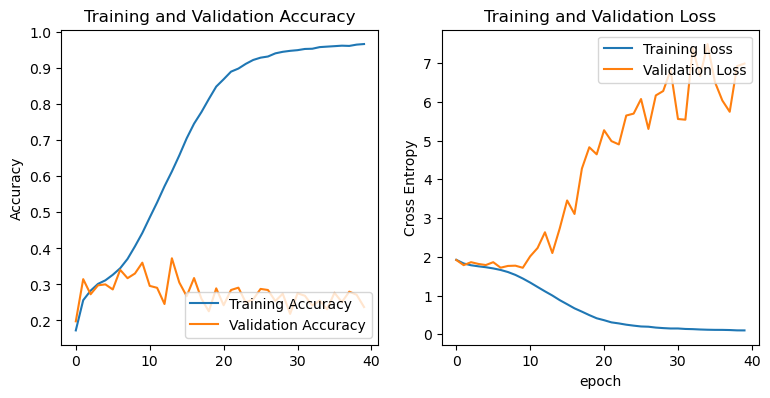

In [14]:
show_history_fit(history)

146/146 [==============================] - 9s 59ms/step - loss: 1.7748 - accuracy: 0.3429
tf.Tensor([1 2 4 ... 5 5 1], shape=(2622,), dtype=int64)
tf.Tensor([2 5 2 ... 5 1 1], shape=(2622,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1980    0.1970    0.1975       203
           1     0.2518    0.1832    0.2121       382
           2     0.7335    0.3953    0.5138      1323
           3     0.0311    0.0980    0.0472        51
           4     0.0929    0.3425    0.1462        73
           5     0.2359    0.5252    0.3255       278
           6     0.2368    0.2885    0.2601       312

    accuracy                         0.3429      2622
   macro avg     0.2543    0.2900    0.2432      2622
weighted avg     0.4785    0.3429    0.3759      2622



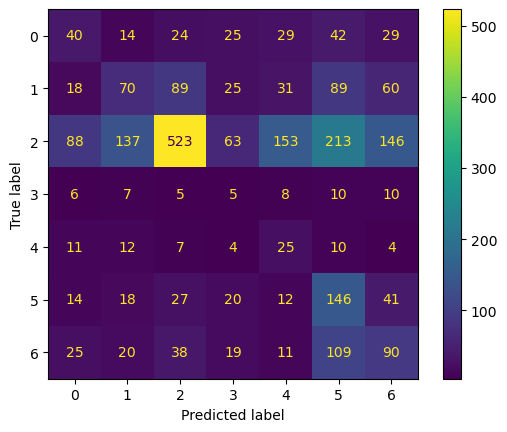

In [15]:
load_best_model_and_evaluate(path_model, test_ds)

## Prove con senza le classi minoritarie (con le reti che hanno dato le migliori performance)